# Long notebook
# Group 9:
## Giulia Montani - 584366
## Paul Alexander Hamelbeck - 584791
## Tiziano Marrone - 584215

# Introduction: Retail Revenue Prediction

In this project, you will predict the revenues of retail stores across all of Norway.

We have been given a large dataset by [Plaace](https://plaace.co/en/), a Norwegian company that matches businesses to retail properties. They have provided us with revenue information for over 20,000 retail stores that will be used to train and evaluate your models. In addition, we have also been provided with a wide selection of supplementary data that can be used to engineer more powerful features, including geo-specific demographic, public transportation information, a hierarchical grouping of the stores, and information about over 28,000 additional stores.

**You may only use the data provided here for your models.** We have made this rule based on experience from previous years to ensure a fair and accurate grading.

This notebook aims to provide you with an introduction to the data. In addition, we give a short tutorial on how to generate and upload a Kaggle submission file. 

## Basics 

We begin by giving a quick overview of the data you've been given, presenting the training and testing set, and introducing the formula we will use to evaluate prediction performance.

### Directory Structure

You are given a collection of comma separated values (csv) files to work with. The two most important files are `stores_train.csv` and `stores_test.csv` which will be covered shortly. The remaining files contain supplementary data that are likely to be useful for crafting a richer feature set. They will be covered later in this notebook.

In [1]:
!ls ./data | sort

'ls' is not recognized as an internal or external command,
operable program or batch file.


### Libraries

In [1]:
import numpy as np

import seaborn as sns

import pandas as pd
import geopandas as gpd
import shapely.geometry as sg

import matplotlib.pyplot as plt 
from matplotlib import gridspec
from collections import Counter

### Stores
Three different data set on the stores: train,test and extra.

From all of them the column 'year' can be removed since the data are collected all in 2016.

### Train Stores

The `stores_train.csv` dataset is the basis for your training data and contains 12859 rows. 
Each store (row) is associated with the following information:
- `store_id`: unique ID for each store 
- `year`: The year the data is recorded for (should all be 2016)
- `store_name`: Human readable name for each store
- `plaace_hierarchy_id`: Group ID for the store type (see [Place Hierarchy](#Plaace-Hierarchy))
- `sales_channel_name`: Human readable name for the store type 
- `grunnkrets_id`: Geographical ID for the store's location (see [Grunnkrets Data](#Grunnkrets-Data))
- `address`: Street address of the store 
- `lat`: Latitude (north-south) coordinate for the store's location 
- `lon`: Longitude (west-east) coordinate for the store's location 
- `chain_name`: Name of the chain the store belongs to (if available)
- `mall_name`: Name of the mall a store is located in (if available)
- `revenue` (**target**): The store's revenue in 2016. This is what you will be predicting.

In [2]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_train = stores_train.drop(columns=['year'])
stores_train.head()

store_id                           store_name  \
0   983540538-974187930-44774  MCDONALD'S BRAGERNES TORG MAGASINET   
1   987074191-973117734-44755           MCDONALD'S KLINGENBERGGATA   
2   984890265-981157303-64491                 BURGER KING HØNEFOSS   
3  914057442-992924179-126912        BURGER KING GLASSHUSPASSASJEN   
4  913018583-913063538-668469             BURGER KING TILLERTORGET   

  plaace_hierarchy_id     sales_channel_name  grunnkrets_id  \
0             1.1.1.0  Hamburger restaurants        6020303   
1             1.1.1.0  Hamburger restaurants        3010306   
2             1.1.1.0  Hamburger restaurants        6050102   
3             1.1.1.0  Hamburger restaurants       18040102   
4             1.1.1.0  Hamburger restaurants       16017414   

             address        lat        lon   chain_name          mall_name  \
0  BRAGERNES TORG 13  59.743104  10.204928    MCDONALDS  Magasinet Drammen   
1                NaN  59.913759  10.734031    MCDONALDS                NaN   
2  KONG RINGS GATE 1  60.164751  10.254656  BURGER KING     Kuben Hønefoss   
3        STORGATA 12  67.283669  14.379796  BURGER KING  Glasshuspassasjen   
4                NaN  63.358068  10.374832  BURGER KING       Tillertorget   

   revenue  
0   17.998  
1   23.828  
2   16.099  
3    9.296  
4    4.528

### Test Stores

The dataset with test stores consists of 8577 rows. Note that it contains the exact same columns as the train set stores, except that the `revenue` column is missing. Your grade in this project will mainly be based on how well you can predict these missing values.

In [3]:
stores_test = pd.read_csv('data/stores_test.csv')
stores_test = stores_test.drop(columns=['year'])
stores_test.head()

store_id                 store_name plaace_hierarchy_id  \
0  914206820-914239427-717245  VÅLERENGA HALAL BURGER AS             1.1.1.0   
1  916789157-916823770-824309          BURGER KING MYREN             1.1.1.0   
2    913341082-977479363-2948        BURGER KING STOVNER             1.1.1.0   
3   889682582-889697172-28720    BURGER KING TUNGASLETTA             1.1.1.0   
4  997991699-998006945-417222           VULKAN BURGERBAR             1.1.1.0   

      sales_channel_name  grunnkrets_id                 address        lat  \
0  Hamburger restaurants        3012704        STRØMSVEIEN 25 A  59.908672   
1  Hamburger restaurants        8061401                 MYREN 1  59.201467   
2  Hamburger restaurants        3013917        STOVNER SENTER 3  59.962146   
3  Hamburger restaurants       16012104          TUNGASLETTA 16  63.420785   
4  Hamburger restaurants        3014305  AUD SCHØNEMANNS VEI 15  59.921102   

         lon        chain_name       mall_name  
0  10.787031               NaN             NaN  
1   9.588243       BURGER KING             NaN  
2  10.924524       BURGER KING  Stovner Senter  
3  10.461091       BURGER KING             NaN  
4  10.785123  VULKAN BURGERBAR             NaN

### Objective 

Because we consider the revenue a continuous variable, we call this a _regression_ problem. It is common to evaluate regression problems according to some deviation measure of the error (difference) between the predictions and the ground truth values. Typical choices are Mean Squared Error (MSE) and its square root, the Root Mean Squared Error (RMSE).

However, both of these measures are quite sensitive to extreme values and work best if the typical scale of prediction errors are consistent across the dataset. This is not likely to be the case here because the revenue variable varies a lot. This means that a, say 10%, prediction error would matter a lot more if it is for one of the higher-earning stores than for one of the lower-earning ones. Consequently, we will use a variation that takes a log transform of the target variable before computing prediction errors.

**TL;DR**: submissions for this problem will be evaluated according to the `Root Mean Squared Log Error` (RMSLE):

- $\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(1 + \hat{y}_i) - \log(1 + y_i))^2}$

In the equation above, $y_i$ corresponds to the ground truth value for datapoint $i$, $\hat{y}_i$ corresponds to the predicted value for datapoint $i$, and $n$ denotes the total number of datapoints (dimensionality of $y$, $\hat{y}$). See the cell below for an implementation.



In [4]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))



# Calculate rmsle for a few example predictions 
y_true = stores_train.revenue.values
n = len(stores_train)
print('A couple of RMSLE scores computed over the train set')
print(f'Perfect prediction: {rmsle(y_true, y_true):.4f}')
print(f'All zeros prediciton: {rmsle(y_true, np.zeros(n)):.4f}')
print(f'All ones prediction: {rmsle(y_true, np.ones(n)):.4f}')

A couple of RMSLE scores computed over the train set
Perfect prediction: 0.0000
All zeros prediciton: 1.8900
All ones prediction: 1.3606


## Supplementary Data 

The following sections cover the remaining data at your disposal.

### Extra Stores 

The extra stores dataset is a collection of stores for which we had no revenue data. Structurally, it is identical to the test set, but you are naturally not expected to submit any predictions for it. You can, however, use the additional data in your analysis, in unsupervised methods you might employ, or to provide a stronger data basis for missing value imputation.


In [5]:
stores_extra = pd.read_csv('data/stores_extra.csv')
stores_extra = stores_extra.drop(columns=['year'])
stores_extra.head()

store_id                       store_name  \
0  911669196-973140302-27020          BURGER KING STRANDGATEN   
1   913155726-992998792-5832  BURGER KING JESSHEIM STORSENTER   
2  988252905-981108604-47887              BURGER KING LANGNES   
3  995194546-891354622-45262    BURGER KING MAGNETEN LEVANGER   
4   881339692-979954964-3203     BURGER KING ULLEVAAL STADION   

  plaace_hierarchy_id     sales_channel_name  grunnkrets_id        address  \
0             1.1.1.0  Hamburger restaurants       12010115  STRANDGATEN 5   
1             1.1.1.0  Hamburger restaurants        2350205     STORGATA 6   
2             1.1.1.0  Hamburger restaurants       19020419  HULDERVEGEN 6   
3             1.1.1.0  Hamburger restaurants       17190701            NaN   
4             1.1.1.0  Hamburger restaurants        3014511  SOGNSVEIEN 75   

         lat        lon   chain_name            mall_name  
0  60.393979   5.323851  BURGER KING                  NaN  
1  60.142760  11.171834  BURGER KING  Jessheim Storsenter  
2  69.671483  18.920483  BURGER KING                  NaN  
3  63.732791  11.281785  BURGER KING             Magneten  
4  59.948558  10.732823  BURGER KING        Amfi Ullevaal

### Plaace Hierarchy 

Plaace has provided us with their system for sorting stores into categories in a 4-level hierarchy. The top level of the hierarchy contains the most abstract groupings ("Dining and Experiences", "Retail", and "Services"). As you move further down in the hierarchy, you get more and more specific categories (109 distinct values at level 4).

Each store is associated with a dot-separated `plaace_hierarchy_id`, which gives its group membership at all four levels of the hierarchy. For instance, the id "2.8.11.2" gives groups "Retail" -> "Food and drinks" -> "Alcohol sales" -> "Beer and soda shop". 

In the cell below we use the `pd.DataFrame.merge` method to perform a left join between the train store data and the hierarchy data, using the `plaace_hierarchy_id` as join key. The result is that each train store row gets corresponding place hierarchy information appended to its side (we just visualize the table vertically to make it easier to see all the columns).

In [6]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')

### Grunnkrets Data 

Next follows information about different regions in Norway and their demography.
A "[Grunnkrets](https://no.wikipedia.org/wiki/Grunnkrets)" is a type of statistical unit used to describe a small geographic area. The corresponding term in english is "[Basic statistical unit](https://en.wikipedia.org/wiki/Basic_statistical_unit_(Norway))".

We have a total of four extra datasets that provides extra information about the different grunnkrets units in Norway: One describing the grunnkrets itself and three describing its demographics.

All the grunnkrets datasets have a column called `grunnkrets_id`. A corresponding column can be found in the `stores_*` datasets, meaning that you can augment each store with information about the grunnkrets it is located in using similar join logic as the `merge` operation used in the previous section.

Note that we have grunnkrets-related data for both 2015 and 2016, but keep in mind that the revenue predictions you will make are all for 2016. Moreover, the demography data is actually for the district, but has already been mapped to each grunnkrets for us.

#### Geography

The first grunnkrets dataset we will look at describes the geography of each grunnkrets. In addition to the official name of the grunnkrets, we also have the district the grunnkrets is located in, as well as the municipality the district is located in. 

Finally, we also have a polygon describing the geographical area covered by the grunnkrets. If you want to process this data further, we recommend you check out the [geopandas](https://geopandas.org) extension. The area of the polygon (in square kilometers) is already computed and available for you to use.

In [7]:
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
grunnkrets = grunnkrets[grunnkrets.year == 2016]
grunnkrets = grunnkrets.drop(columns=['year'])
gs = gpd.GeoSeries.from_wkt(grunnkrets['geometry'])
cgs = gs.centroid
grunnkrets['lon_centroid'] = cgs.x
grunnkrets['lat_centroid'] = cgs.y
grunnkrets.head()

grunnkrets_id        grunnkrets_name               district_name  \
260       10010507     Fidjane-Vestheiene            Hellemyr-Fjellro   
261       10011105       Gimlekollen vest  Kongsgård øvre-Gimlekollen   
262       10011604                   Ryen                       Tveit   
263       10011703             Hånes vest               Hånes-Timenes   
264       10011707  Hånes Nord-Bjørndalen               Hånes-Timenes   

    municipality_name                                           geometry  \
260      Kristiansand  MULTIPOLYGON(((7.93581993399791 58.14261844480...   
261      Kristiansand  MULTIPOLYGON(((8.02862690742917 58.17389896051...   
262      Kristiansand  POLYGON((8.10303607445248 58.2119345268037, 8....   
263      Kristiansand  POLYGON((8.08896547903471 58.1756869597767, 8....   
264      Kristiansand  POLYGON((8.09775611761549 58.1741474661755, 8....   

     area_km2  lon_centroid  lat_centroid  
260  0.158484      7.921513     58.145116  
261  0.474242      8.020335     58.172174  
262  1.464307      8.102712     58.220044  
263  0.484497      8.086559     58.171970  
264  0.388282      8.092928     58.180749

District name is a sub cathegory of municipality name.
Maybe is better to keep just one and not both of them! Don't know yet wich one

#### Age Distribution

Next, we have information about the age distribution in different grunnkrets units. Each column gives the number of people of a given age that lives in the grunnkrets. For instance, the `12` in the first row of column `age_6` means that there are 12 six-year-olds in the corresponding grunnkrets.

In [8]:
grunnkrets_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
grunnkrets_ages = grunnkrets_ages[grunnkrets_ages.year == 2016]
grunnkrets_ages = grunnkrets_ages.drop(columns=['year'])
grunnkrets_ages.head()

grunnkrets_id  age_0  age_1  age_2  age_3  age_4  age_5  age_6  age_7  \
1        16013117     10     10     10     10     10     10      9      9   
3        16011203      2      2      2      2      2      3      3      3   
4         3011601      7      7      7      7      6      6      5      4   
8         3010807      3      3      3      3      3      3      2      2   
11        3012307      4      4      4      4      4      4      4      4   

    age_8  ...  age_81  age_82  age_83  age_84  age_85  age_86  age_87  \
1       7  ...       0       0       0       0       0       0       0   
3       3  ...       1       1       1       1       1       1       1   
4       4  ...       1       1       0       0       0       0       0   
8       2  ...       1       1       1       0       0       0       0   
11      4  ...       0       0       0       0       0       0       0   

    age_88  age_89  age_90  
1        0       0       0  
3        0       0       0  
4        0       0       0  
8        0       0       0  
11       0       0       0  

[5 rows x 92 columns]

#### Household Types 

The second demography dataset gives the household composition in each grunnkrets. The different types of households are partitioned into 8 categories. Each column gives the number of households in a given category.

In [9]:
grunnkrets_household_types = pd.read_csv('data/grunnkrets_households_num_persons.csv')
grunnkrets_household_types = grunnkrets_household_types[grunnkrets_household_types.year == 2016]
grunnkrets_household_types = grunnkrets_household_types.drop(columns=['year'])
grunnkrets_household_types.head()

grunnkrets_id  couple_children_0_to_5_years  \
3969       10011701                             8   
3970       11350102                             0   
3971       18530117                             0   
3972       20030403                             0   
3973        4020519                             0   

      couple_children_18_or_above  couple_children_6_to_17_years  \
3969                            0                              0   
3970                            0                              0   
3971                            0                              0   
3972                            0                              0   
3973                            0                              0   

      couple_without_children  single_parent_children_0_to_5_years  \
3969                        0                                    0   
3970                        0                                    0   
3971                        0                                    0   
3972                        0                                    0   
3973                        0                                    0   

      single_parent_children_18_or_above  \
3969                                   0   
3970                                   0   
3971                                   0   
3972                                   0   
3973                                   0   

      single_parent_children_6_to_17_years  singles  
3969                                     0        3  
3970                                     0        5  
3971                                     0        3  
3972                                     0        7  
3973                                     0        3

#### Household Income

The last demography dataset gives median incomes in each grunnkrets. The first income column is `all_households`, which denotes the median income aggregated across all households in the grunnkrets. The last three columns further breaks this figure down for three different types of households.

In [10]:
grunnkrets_household_income = pd.read_csv('data/grunnkrets_income_households.csv')
grunnkrets_household_income = grunnkrets_household_income[grunnkrets_household_income.year == 2016]
grunnkrets_household_income = grunnkrets_household_income.drop(columns=['year'])
grunnkrets_household_income.head()

grunnkrets_id  all_households  singles  couple_without_children  \
0        14200105          551700   270300                        0   
3        14200401          507000   250700                        0   
11       14200402          507000   250700                        0   
12       14200101          551700   270300                        0   
13       14200103          551700   270300                        0   

    couple_with_children  other_households  single_parent_with_children  
0                      0                 0                            0  
3                      0                 0                            0  
11                     0                 0                            0  
12                     0                 0                            0  
13                     0                 0                            0

### Busstops

Lastly, we also have information about bus stops all over Norway. Unlike the previous datasets, none of the rows here are directly associated with any of the stores. However, the `geometry` column contains information about the location, which can be compared with the location of stores to generate features.

- `busstop_id`: unique ID for busstop. Not tied to anything else in this dataset 
- `stopplace_type`: what kind of stop it is (e.g. just a curbside stop or a proper bus pocket)
- `importance_level`: how important the stop is (e.g. just a regular stop or a regional hub)
- `side_placement`: position in the road 
- `geometry`: latitude and longitude of location (point geometry)

In [11]:
busstops = pd.read_csv('data/busstops_norway.csv')
busstops.head()

busstop_id                  stopplace_type  \
0  853cb081-cc32-4880-aa3e-26e96870d874              Plattform og lomme   
1  156b052b-2771-497a-b4f4-97fed59e1aca  Lomme og skilt, ikke plattform   
2  7312a280-e14f-4b09-a421-02e8fe1bc63e                             NaN   
3  d9cda2c7-355a-49c1-b56c-a33180d2a82e                             NaN   
4  f803bcd3-182d-450b-bbb4-113c6ca885c2                             NaN   

         importance_level  side_placement  \
0  Mangler viktighetsnivå  LEFT_AND_RIGHT   
1  Mangler viktighetsnivå  LEFT_AND_RIGHT   
2  Mangler viktighetsnivå     MIDDLE_LEFT   
3  Mangler viktighetsnivå     MIDDLE_LEFT   
4  Mangler viktighetsnivå    MIDDLE_RIGHT   

                                   geometry  
0  POINT(6.54064723379766 61.0618887850553)  
1  POINT(5.89980086113255 60.1421872817075)  
2  POINT(10.7781327278563 59.9299988828761)  
3  POINT(10.7781496457324 59.9301044643692)  
4  POINT(10.7781676444854 59.9302099995898)

## Getting Started

In this final section, we will go through a sped-up and simplified version of the work we expect you to do; all the way from initial EDA, to "training" a very simple model, and finally using the model to make a submission with test set predictions.

### Analyzing the Data

The first thing you should do is start exploring the data. We often refer to this activity as Exploratory Data Analysis (EDA). In the cell below we make two plots. The first one shows the number of missing values in the `stores_train` dataframe. The second one visualizes the distribution of the target variable (revenue).

In your own work, you should go a lot further than this. You may for instance want to:

- Look for outliers and other parts of the data that should be cleaned up
- Investigate to what degree single variables correlate, both with each other and the target variable
- Visualize different variables spatially, perhaps with maps in the background



## New features
Stores train: A column for log revenue and two categorical features to grouping the revenues.

In [12]:
eps = 0.01
stores_train['log_revenue'] = np.log10(stores_train.revenue+eps)
stores_train['cat_revenue'] = pd.cut(stores_train['revenue'],
                                     bins=[-1,10,80,np.inf],
                                    labels=["low", "medium", "high"])                                     
stores_train['cat_log_revenue'] = pd.cut(stores_train['log_revenue'],
                                        bins=[-4,-1,0,1,np.inf],
                                        labels=['lowest','low','medium','high'])

Grunnkrets geography: area_M describe the area of the municipality.

In [13]:
area_M = grunnkrets.groupby('municipality_name')[['area_km2']].sum()
grunnkrets = grunnkrets.merge(area_M,how='left', on='municipality_name')
grunnkrets.rename(columns={'area_km2_x':'area_km2_grunnkrets','area_km2_y':'area_km2_municipality'},inplace=True)
grunnkrets['cat_area'] = pd.cut(grunnkrets['area_km2_grunnkrets'],
                                bins=[0, 2,5, 10, np.inf],
                                #bins= 3,
                                labels=["small1","small2", "medium", "big"])
grunnkrets['cat_area_M'] = pd.cut(grunnkrets['area_km2_municipality'],
                                bins=[0, 30, 100, np.inf],
                                #bins= 3,
                                labels=["small1", "medium", "big"])

Grunnkrets population: Number of population in each grunnkrets and in each municipality;
Average age in each grunnkrets;
Categorical features for age category, numerosity of the population

In [14]:
pop = grunnkrets_ages.drop(columns=['grunnkrets_id'])
grunnkrets_ages = grunnkrets_ages[['grunnkrets_id']]
mean_grunnkrets_age = np.divide((pop*np.array([range(0,91)])).sum(axis=1),np.sum(pop.T))
grunnkrets_ages['pop_grunnkrets'] = np.sum(pop.T)
grunnkrets_ages['mean_age'] = mean_grunnkrets_age
grunnkrets_ages['pop_0_18'] = np.sum(pop.loc[:,'age_0':'age_18'].T)
grunnkrets_ages['pop_19_36'] = np.sum(pop.loc[:,'age_19':'age_36'].T)
grunnkrets_ages['pop_37_54'] = np.sum(pop.loc[:,'age_37':'age_54'].T)
grunnkrets_ages['pop_55_72'] = np.sum(pop.loc[:,'age_55':'age_72'].T)
grunnkrets_ages['pop_over_73'] = np.sum(pop.loc[:,'age_73':].T)

grunnkrets_ages = grunnkrets_ages.merge(grunnkrets[['grunnkrets_id','municipality_name']],how='left',on='grunnkrets_id')
pop_M = grunnkrets_ages.groupby('municipality_name')[['pop_grunnkrets']].sum()
grunnkrets_ages = grunnkrets_ages.merge(pop_M,how='left', on='municipality_name')
grunnkrets_ages.rename(columns={'pop_grunnkrets_x':'pop_grunnkrets','pop_grunnkrets_y':'pop_municipality'},inplace=True)

grunnkrets_ages['amount_pop_grunnkrets'] = pd.cut(grunnkrets_ages['pop_grunnkrets'],
                                       bins=[-1,200,600,np.inf],
                                    labels=['few','normal','alot'])
grunnkrets_ages['cat_age_grunnkrets'] = pd.cut(grunnkrets_ages['mean_age'],
                                 bins=[-1,25,40,60,np.inf],
                                labels=['young','teenager','adult','senior'])
grunnkrets_ages['amount_pop_municipality'] = pd.cut(grunnkrets_ages['pop_municipality'],
                                       bins=[-1,30000,150000,np.inf],
                                    labels=['few','normal','alot'])

Grunnkrets household type

In [15]:
grunnkrets_household_types['number_household'] = np.sum(grunnkrets_household_types.loc[:,'couple_children_0_to_5_years':].T)

# EDA 

## Stores train, test and extra

### Nan

Text(0.5, 1.0, 'Fraction of rows with NaN values in extra')

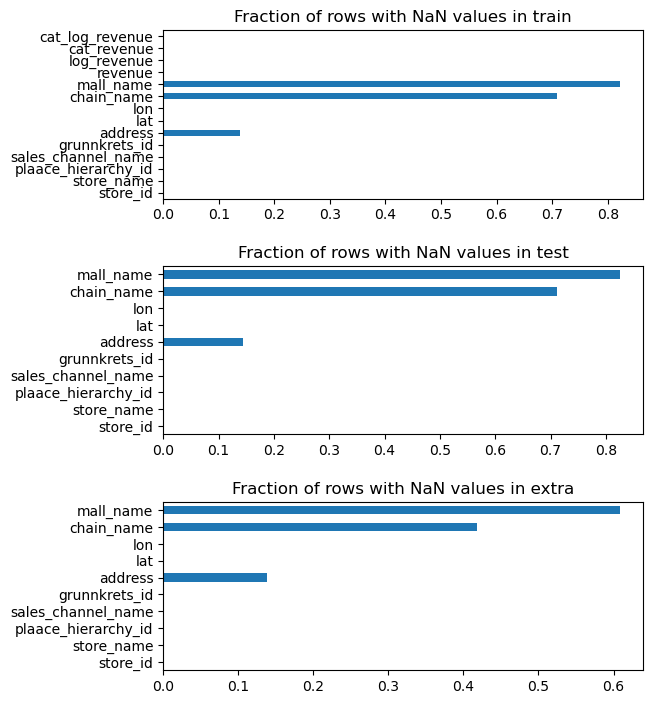

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6, 8),nrows=3, dpi=100)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
stores_train.isna().mean().plot(kind='barh',ax=ax1)
stores_test.isna().mean().plot(kind='barh',ax=ax2)
stores_extra.isna().mean().plot(kind='barh',ax=ax3)

ax1.set_title('Fraction of rows with NaN values in train')
ax2.set_title('Fraction of rows with NaN values in test')
ax3.set_title('Fraction of rows with NaN values in extra')


Address is an unique number and can be removed from the features

In [17]:
stores_train = stores_train.drop(columns=['address'])
stores_test = stores_test.drop(columns=['address'])
stores_extra = stores_extra.drop(columns=['address'])


In [18]:
stores_train.chain_name[stores_train.chain_name.isna()] = 'No chain'
stores_train.mall_name[stores_train.mall_name.isna()] = 'No mall'
stores_test.chain_name[stores_test.chain_name.isna()] = 'No chain'
stores_test.mall_name[stores_test.mall_name.isna()] = 'No mall'
stores_extra.chain_name[stores_extra.chain_name.isna()] = 'No chain'
stores_extra.mall_name[stores_extra.mall_name.isna()] = 'No mall'


C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate f

## Revenue 
(only train)

Distribution

Highest revenue 219.599
Lowest revenue 0.0


C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


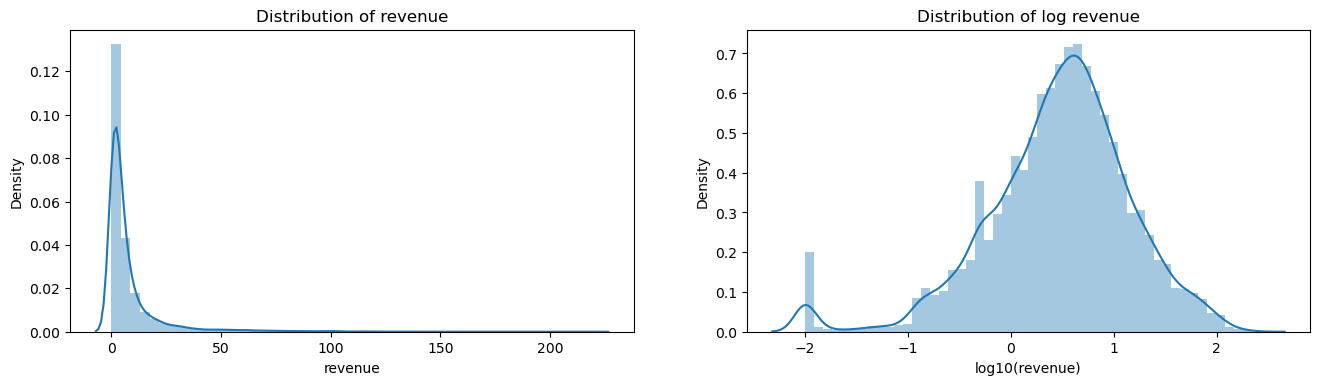

In [19]:
print('Highest revenue', np.max(stores_train.revenue))
print('Lowest revenue', np.min(stores_train.revenue))

# add eps = 0.001 to avoid log10(0)
eps=0.01
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
sns.distplot(stores_train.revenue.rename('revenue'), ax=ax1)
ax1.set_title('Distribution of revenue');
sns.distplot(np.log10(stores_train.revenue+eps).rename('log10(revenue)'), ax=ax2)
ax2.set_title('Distribution of log revenue');

Numerosity of the category

Text(0.5, 1.0, 'Log revenue category')

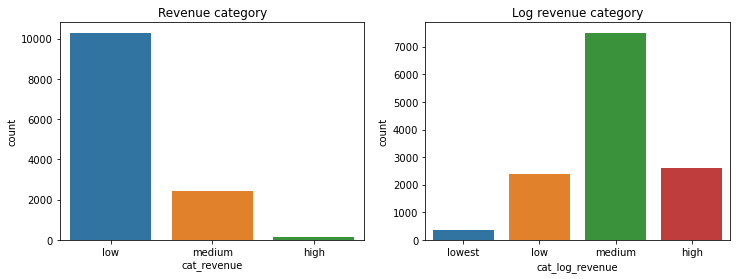

In [20]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,4),ncols=2)
sns.countplot(data=stores_train,x='cat_revenue',ax=ax1)
ax1.set_title('Revenue category')
sns.countplot(data=stores_train,x='cat_log_revenue',ax=ax2)
ax2.set_title('Log revenue category')

### Outlier detection for revenue

In [21]:
print('% stores with revenue bigger than 80: ' ,np.sum(stores_train.revenue>80)/np.shape(stores_train)[0] * 100)

% stores with revenue bigger than 80:  1.0187417373046115


Only 1% of the stores have revenue higher than 80 and the range of the revenue is from 0 to 219.

Check if they can be classified as outlier.

Analyze location, sales channel name, chain name and mall name.

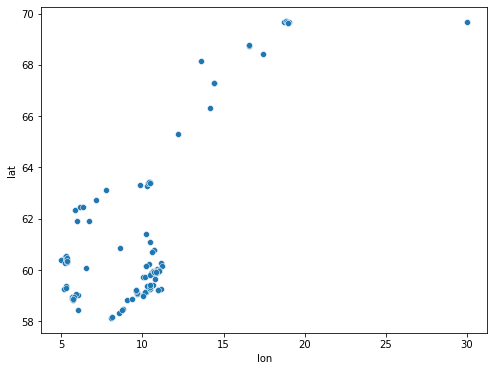

In [22]:
plt.subplots(figsize=(8,6))
sns.scatterplot(data = stores_train[stores_train.cat_revenue=='high'], x='lon',y='lat')

Text(0.5, 1.0, 'Mall name')

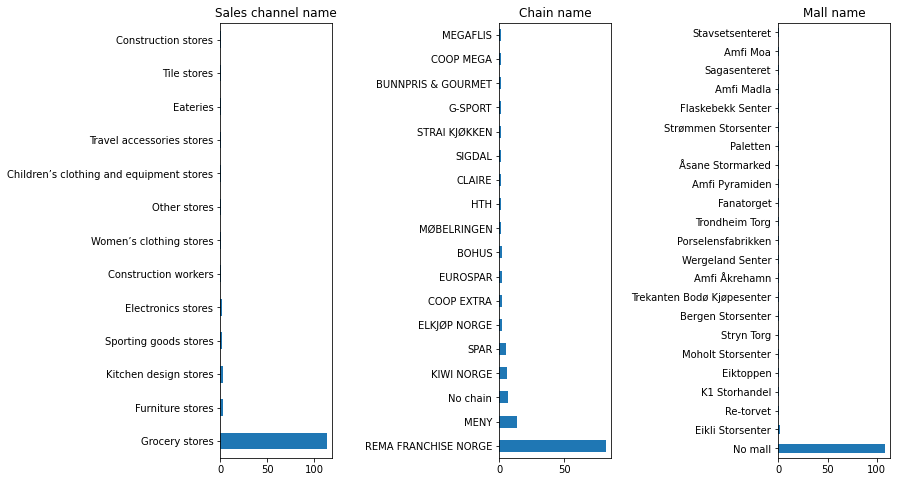

In [23]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,8),nrows=1,ncols=3)
plt.subplots_adjust(wspace=1.5)
plt.title('High revenue')
stores_train[stores_train.cat_revenue=='high'].sales_channel_name.value_counts().plot(kind='barh',ax=ax1)
ax1.set_title('Sales channel name')
stores_train[stores_train.cat_revenue=='high'].chain_name.value_counts().plot(kind='barh',ax=ax2)
ax2.set_title('Chain name')
stores_train[stores_train.cat_revenue=='high'].mall_name.value_counts().plot(kind='barh',ax=ax3)
ax3.set_title('Mall name')


Seems that the stores with high revenue are of the category 'grocery stops' and from the chain name it's evident that they are supermarket. Most of them aren't in a mall.

In the following there are some countplot for different value of revenue for each category, identified from the highest values of revenue.

Text(0.5, 1.0, 'No mall')

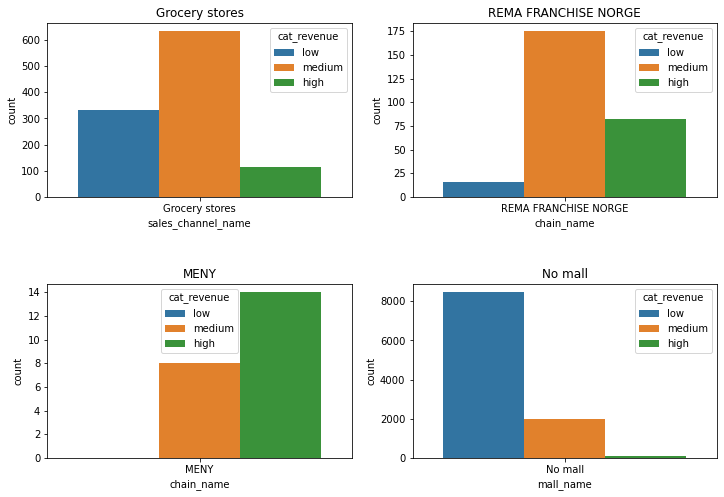

In [24]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(12,8),nrows=2,ncols=2)
plt.subplots_adjust(hspace=0.5)
sns.countplot(data=stores_train[stores_train.sales_channel_name=='Grocery stores'], x='sales_channel_name',hue="cat_revenue",ax=ax1)
ax1.set_title('Grocery stores')
sns.countplot(data=stores_train[stores_train.chain_name=='REMA FRANCHISE NORGE'], x='chain_name',hue="cat_revenue",ax=ax2)
ax2.set_title('REMA FRANCHISE NORGE')
sns.countplot(data=stores_train[stores_train.chain_name=='MENY'], x='chain_name',hue="cat_revenue",ax=ax3)
ax3.set_title('MENY')
sns.countplot(data=stores_train[stores_train.mall_name=='No mall'], x='mall_name',hue="cat_revenue",ax=ax4)
ax4.set_title('No mall')

The chain supermarket such as REMA FRANCHISE NORGE and MENY are characterized by high revenue.

The revenue for the grocery stores isn't in the category of high revenue for all the grocery stores but for most of them.

Instead for the stores that aren't in a mall the revenue isn't high. The results obtained before are explained by the fact that most of the stores aren't in a mall and becouse there isn't a mall charcaterized by stores with high revenue only.

Conclusion: We decide to keep also the high values even if they are few since they explain the behvaiour of some specific stores.

### Outlier detection for log revenue

The most outliers are positioned close to larger cities, which makes sense as a position for the shops with the highest revenue

% stores with log revenue = -2, equivalent to stores with revenue =0:  2.667392487751769


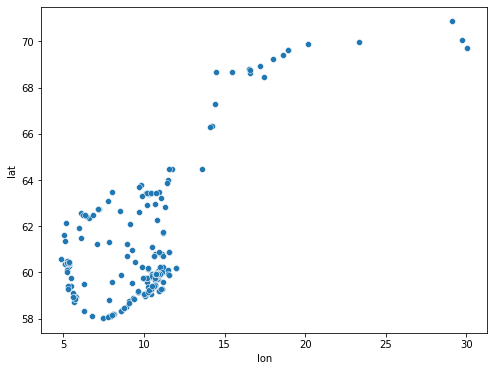

In [25]:
print('% stores with log revenue = -2, equivalent to stores with revenue =0: ',len(stores_train[stores_train.cat_log_revenue=='lowest'])/len(stores_train)*100)
plt.subplots(figsize=(8,6))
sns.scatterplot(data=stores_train[stores_train.cat_log_revenue=='lowest'],x='lon',y='lat')

Text(0.5, 1.0, 'Mall name')

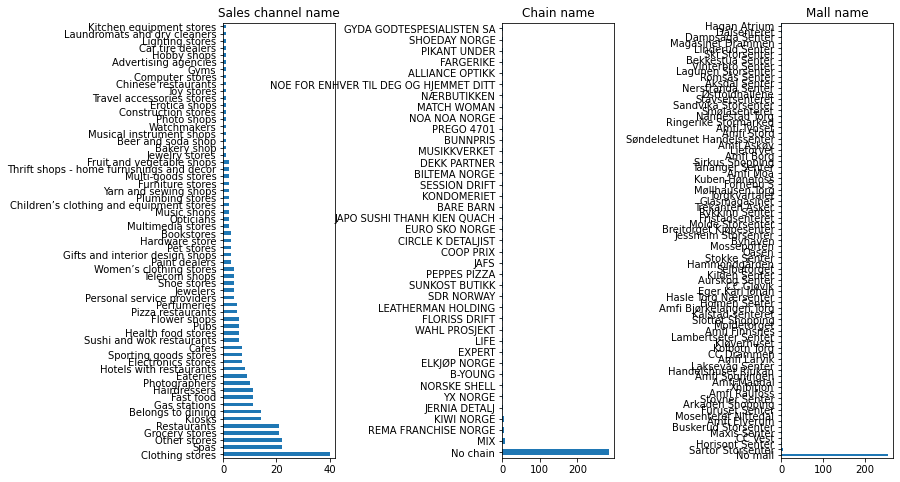

In [26]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,8),nrows=1,ncols=3)
plt.subplots_adjust(wspace=1.5)
plt.title('Low log revenue, null revenue')
stores_train[stores_train.cat_log_revenue=='lowest'].sales_channel_name.value_counts().plot(kind='barh',ax=ax1)
ax1.set_title('Sales channel name')
stores_train[stores_train.cat_log_revenue=='lowest'].chain_name.value_counts().plot(kind='barh',ax=ax2)
ax2.set_title('Chain name')
stores_train[stores_train.cat_log_revenue=='lowest'].mall_name.value_counts().plot(kind='barh',ax=ax3)
ax3.set_title('Mall name')

Text(0.5, 1.0, 'No mall')

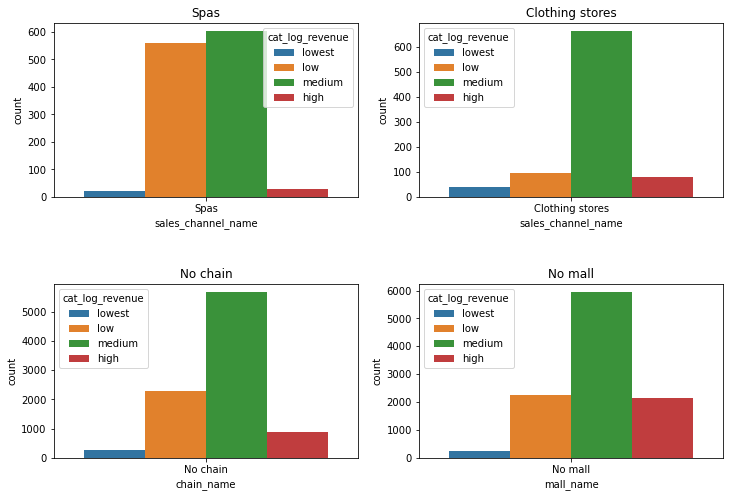

In [27]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(12,8),nrows=2,ncols=2)
plt.subplots_adjust(hspace=0.5)
sns.countplot(data=stores_train[stores_train.sales_channel_name=='Spas'], x='sales_channel_name',hue="cat_log_revenue",ax=ax1)
ax1.set_title('Spas')
sns.countplot(data=stores_train[stores_train.sales_channel_name=='Clothing stores'], x='sales_channel_name',hue="cat_log_revenue",ax=ax2)
ax2.set_title('Clothing stores')
sns.countplot(data=stores_train[stores_train.chain_name=='No chain'], x='chain_name',hue="cat_log_revenue",ax=ax3)
ax3.set_title('No chain')
sns.countplot(data=stores_train[stores_train.mall_name=='No mall'], x='mall_name',hue="cat_log_revenue",ax=ax4)
ax4.set_title('No mall')

In this case the analysis shows that the stores with low log revenue, equivalent to null revenue, don't have common aspects.

## Column analysis for train and test set

### Latitude and Longitude

Text(0.5, 1.0, 'Stores in test set')

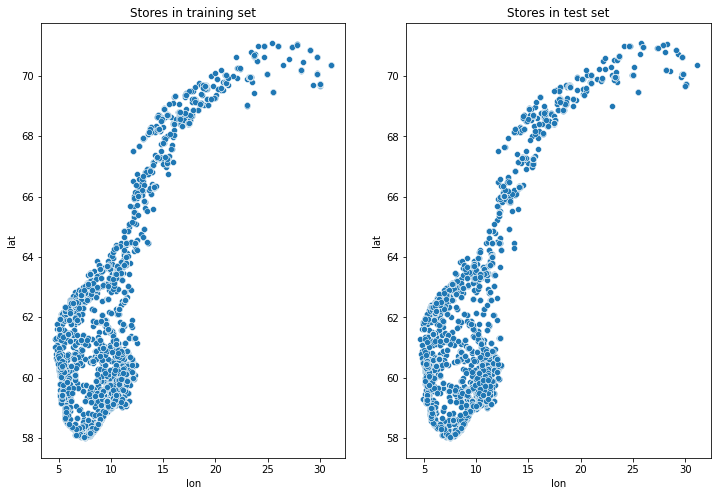

In [28]:
fig,(ax1,ax2) = plt.subplots(figsize=(12,8),ncols=2)
sns.scatterplot(data= stores_train, x='lon',y='lat',ax=ax1)
ax1.set_title('Stores in training set')
sns.scatterplot(data= stores_test, x='lon',y='lat',ax=ax2)
ax2.set_title('Stores in test set')

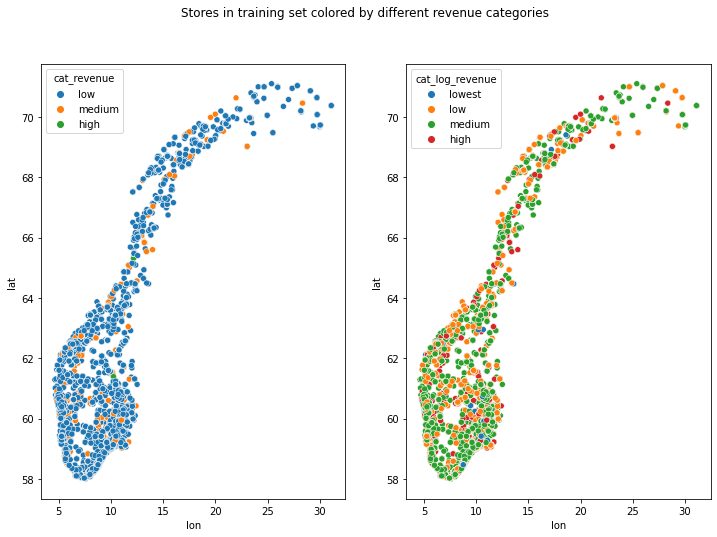

In [29]:
fig,(ax1,ax2) = plt.subplots(figsize=(12,8),ncols=2)
fig.suptitle('Stores in training set colored by different revenue categories')
sns.scatterplot(data= stores_train, x='lon',y='lat',hue='cat_revenue',ax=ax1)
sns.scatterplot(data= stores_train, x='lon',y='lat',hue='cat_log_revenue',ax=ax2)

### Sales channel name

Text(0.5, 1.0, 'Sales channel name in test set')

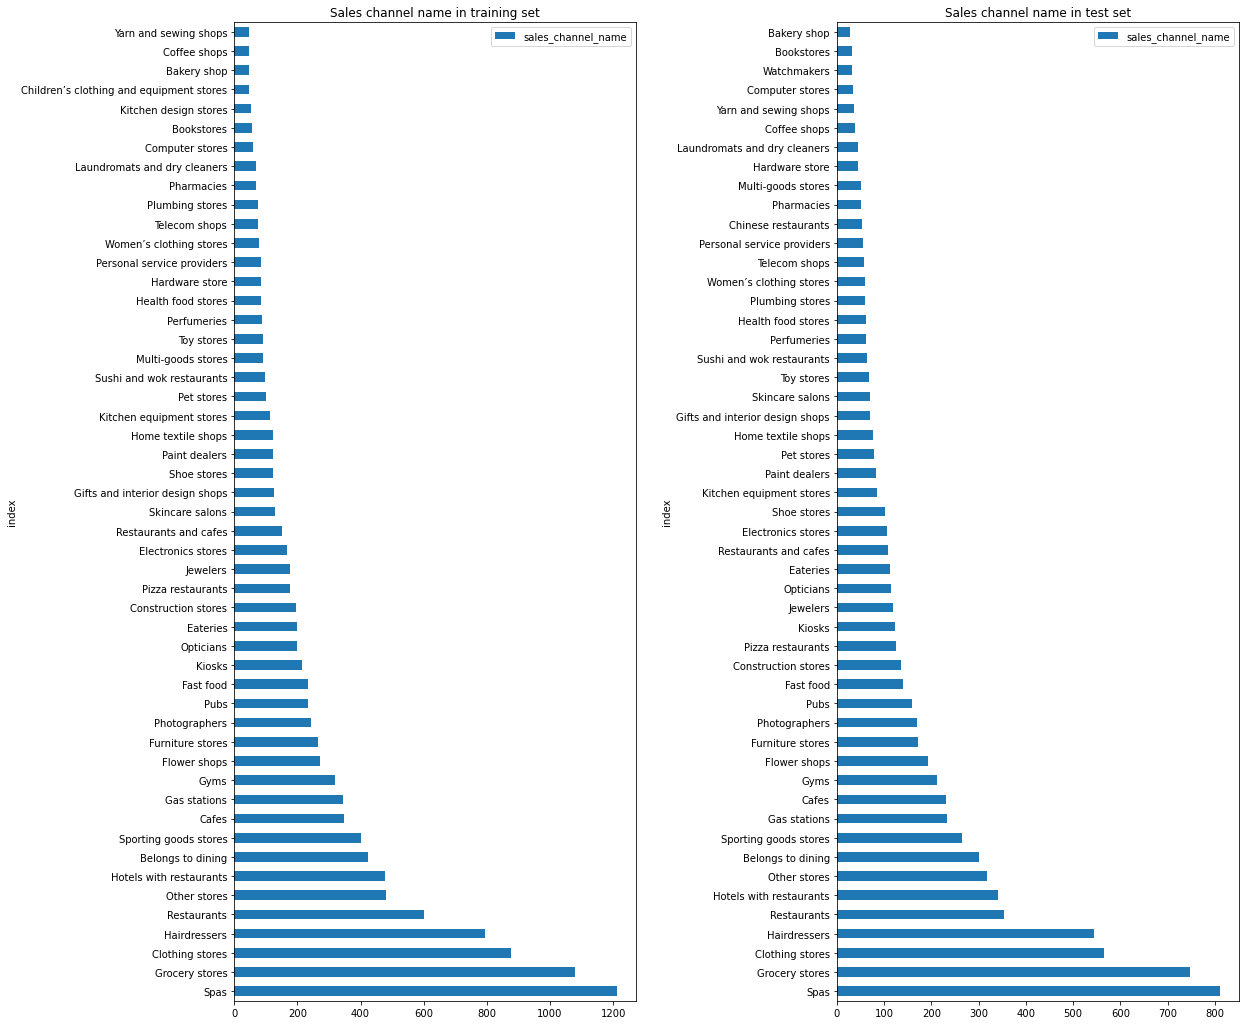

In [30]:
fig, (ax1,ax2) = plt.subplots(figsize=(18,18),ncols=2)
plt.subplots_adjust(wspace=0.5)
stores_train.sales_channel_name.value_counts().reset_index().truncate(after=50).set_index('index').plot(kind='barh',ax=ax1)
ax1.set_title('Sales channel name in training set')
stores_test.sales_channel_name.value_counts().reset_index().truncate(after=50).set_index('index').plot(kind='barh',ax=ax2)
ax2.set_title('Sales channel name in test set')

### Chain name

Text(0.5, 1.0, 'Chain name in test set')

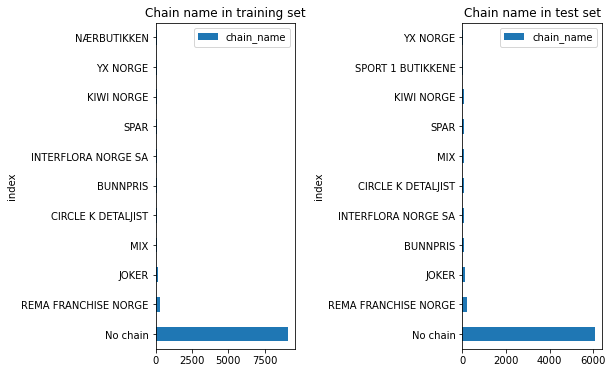

In [31]:
fig, (ax1,ax2) = plt.subplots(figsize=(8,6),ncols=2)
plt.subplots_adjust(wspace=1.2)
stores_train.chain_name.value_counts().reset_index().truncate(after=10).set_index('index').plot(kind='barh',ax=ax1)
ax1.set_title('Chain name in training set')
stores_test.chain_name.value_counts().reset_index().truncate(after=10).set_index('index').plot(kind='barh',ax=ax2)
ax2.set_title('Chain name in test set')

Stores that doens't belong to a chain are more than the others. 

Try to visualize better without the chain.

Text(0.5, 1.0, 'Chain name in test set')

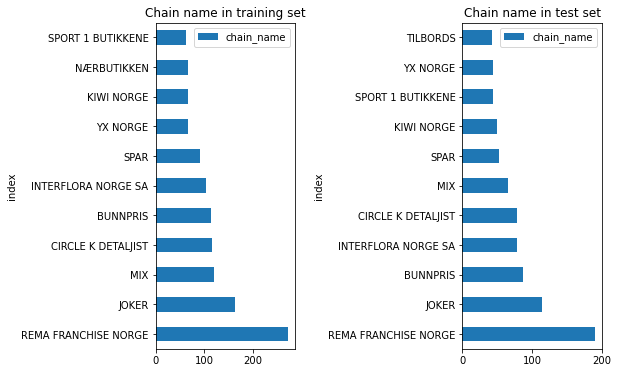

In [32]:
fig, (ax1,ax2) = plt.subplots(figsize=(8,6),ncols=2)
plt.subplots_adjust(wspace=1.2)
stores_train[stores_train.chain_name!='No chain'].chain_name.value_counts().reset_index().truncate(after=10).set_index('index').plot(kind='barh',ax=ax1)
ax1.set_title('Chain name in training set')
stores_test[stores_test.chain_name!='No chain'].chain_name.value_counts().reset_index().truncate(after=10).set_index('index').plot(kind='barh',ax=ax2)
ax2.set_title('Chain name in test set')

### Mall name

Text(0.5, 1.0, 'Mall name in test set')

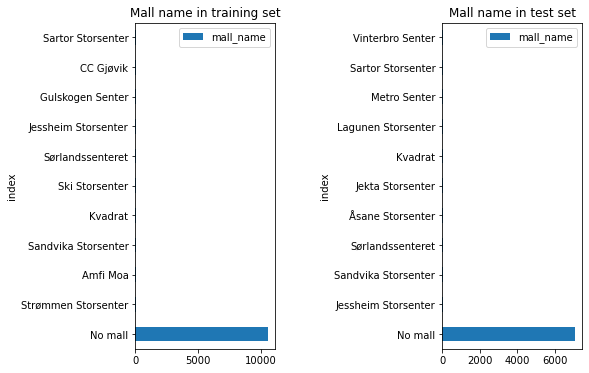

In [33]:
fig, (ax1,ax2) = plt.subplots(figsize=(8,6),ncols=2)
plt.subplots_adjust(wspace=1.2)
stores_train.mall_name.value_counts().reset_index().truncate(after=10).set_index('index').plot(kind='barh',ax=ax1)
ax1.set_title('Mall name in training set')
stores_test.mall_name.value_counts().reset_index().truncate(after=10).set_index('index').plot(kind='barh',ax=ax2)
ax2.set_title('Mall name in test set')

Text(0.5, 1.0, 'Mall name in test set')

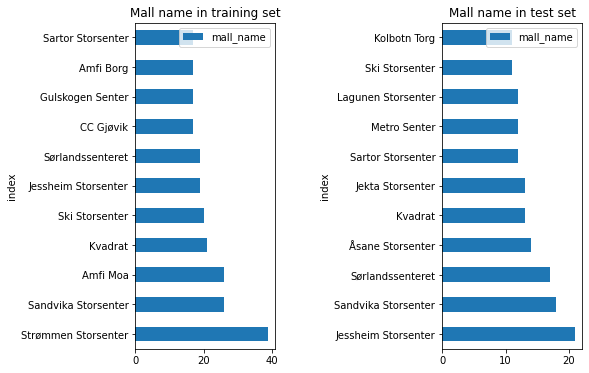

In [34]:
fig, (ax1,ax2) = plt.subplots(figsize=(8,6),ncols=2)
plt.subplots_adjust(wspace=1.2)
stores_train[stores_train.mall_name!='No mall'].mall_name.value_counts().reset_index().truncate(after=10).set_index('index').plot(kind='barh',ax=ax1)
ax1.set_title('Mall name in training set')
stores_test[stores_test.mall_name!='No mall'].mall_name.value_counts().reset_index().truncate(after=10).set_index('index').plot(kind='barh',ax=ax2)
ax2.set_title('Mall name in test set')

### Pair plot for continuous features

Text(0.5, 1.05, 'Pair plot of numerical features with log revenue category color')

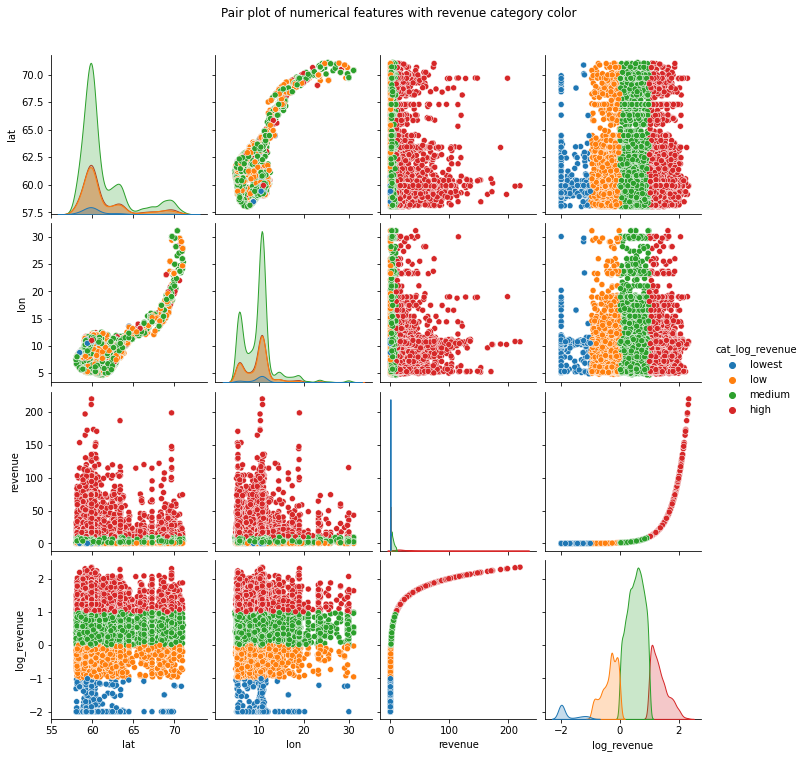

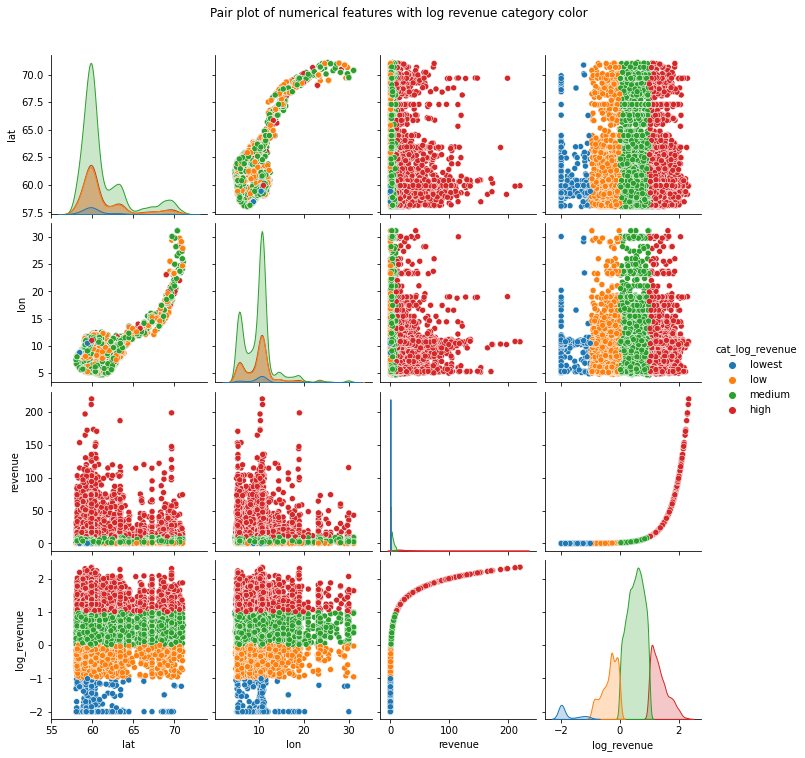

In [35]:
g1 = sns.pairplot(stores_train.drop(columns=['grunnkrets_id']),hue='cat_log_revenue')
g1.fig.suptitle('Pair plot of numerical features with revenue category color',y=1.05)

g2= sns.pairplot(stores_train.drop(columns=['grunnkrets_id']),hue='cat_log_revenue')
g2.fig.suptitle('Pair plot of numerical features with log revenue category color',y=1.05)


### Anova for categorical features

H0: No difference among group means vs H1: There is a difference among group means

In [36]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [37]:
anova = ols('revenue ~ plaace_hierarchy_id +chain_name+mall_name',data=stores_train).fit()
sm.stats.anova_lm(anova, typ=2)

sum_sq       df          F        PR(>F)
plaace_hierarchy_id  5.384279e+04     90.0   6.763893  1.254290e-75
chain_name           8.251945e+05    306.0  30.489240  0.000000e+00
mall_name            1.027783e+05    487.0   2.386076  3.266067e-53
Residual             1.059342e+06  11977.0        NaN           NaN

The p-value are low and therefore we can reject the null hypothesis

## Stores with hierarchy

In [38]:
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on=['plaace_hierarchy_id','sales_channel_name'])
test_stores_with_hierarchy = stores_test.merge(plaace_hierarchy, how='left', on=['plaace_hierarchy_id','sales_channel_name'])

### Analysis level 1 and 2

Distribution of different shop types across the data set was explored and visualized

([<matplotlib.patches.Wedge at 0x15f9af9b2e8>,
 [Text(-0.5097379966472145, 0.9747651895580209, 'Beauty and wellbeing (3.1)'),
  Text(0.03881185239496903, -1.0993150777250675, 'Professionals (3.2)'),
  Text(0.80450723544862, -0.750178717447262, 'Other Services (3.3)'),
  Text(0.9029567001221237, -0.6282270272000126, 'Agencies (3.4)'),
  Text(1.0495838575505418, -0.329201649402496, 'Gyms (3.5)')])

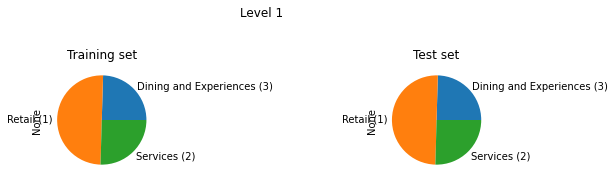

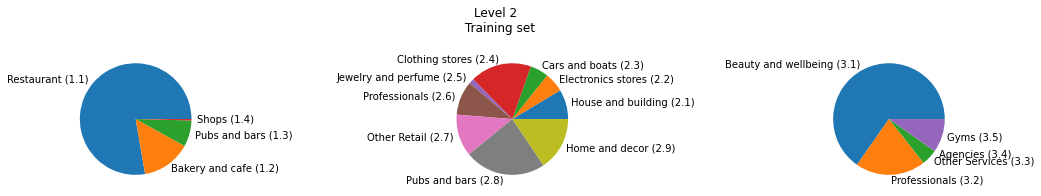

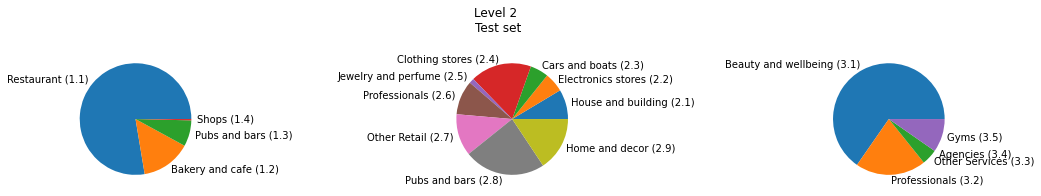

In [39]:
label_lv1 = ["Dining and Experiences (3)","Retail (1)","Services (2)"]

fig, (ax1,ax2) = plt.subplots(figsize=(8,8),nrows=1,ncols=2)
plt.suptitle('Level 1',y=0.7)
plt.subplots_adjust(wspace=2)
stores_with_hierarchy.groupby('lv1').size().plot(kind='pie',labels= label_lv1,ax=ax1)
ax1.set_title('Training set')
test_stores_with_hierarchy.groupby('lv1').size().plot(kind='pie',labels= label_lv1,ax=ax2)
ax2.set_title('Test set')

g1 = stores_with_hierarchy.lv1==1
g2 = stores_with_hierarchy.lv1==2
g3 = stores_with_hierarchy.lv1==3
ng = len(test_stores_with_hierarchy.lv1)
g1t = test_stores_with_hierarchy.lv1==1
g2t = test_stores_with_hierarchy.lv1==2
g3t = test_stores_with_hierarchy.lv1==3
ngt = len(test_stores_with_hierarchy.lv1)

g11 = stores_with_hierarchy.lv2==1.1
g12 = stores_with_hierarchy.lv2==1.2
g13 = stores_with_hierarchy.lv2==1.3
g14 = stores_with_hierarchy.lv2==1.4
p1_lv2 = np.array([sum(g11==True)/sum(g1==True),sum(g12==True)/sum(g1==True),sum(g13==True)/sum(g1==True),sum(g14==True)/sum(g1==True)])*100
label1_lv2 = ["Restaurant (1.1)","Bakery and cafe (1.2)","Pubs and bars (1.3)","Shops (1.4)"]

g11t = test_stores_with_hierarchy.lv2==1.1
g12t = test_stores_with_hierarchy.lv2==1.2
g13t = test_stores_with_hierarchy.lv2==1.3
g14t = test_stores_with_hierarchy.lv2==1.4
p1_lv2t = np.array([sum(g11t==True)/sum(g1t==True),sum(g12t==True)/sum(g1t==True),sum(g13t==True)/sum(g1t==True),
                    sum(g14t==True)/sum(g1t==True)])*100
label1_lv2t = ["Restaurant (1.1)","Bakery and cafe (1.2)","Pubs and bars (1.3)","Shops (1.4)"]

g21 = stores_with_hierarchy.lv2==2.1
g22 = stores_with_hierarchy.lv2==2.2
g23 = stores_with_hierarchy.lv2==2.3
g24 = stores_with_hierarchy.lv2==2.4
g25 = stores_with_hierarchy.lv2==2.5
g26 = stores_with_hierarchy.lv2==2.6
g27 = stores_with_hierarchy.lv2==2.7
g28 = stores_with_hierarchy.lv2==2.8
g29 = stores_with_hierarchy.lv2==2.9
p2_lv2 = np.array([sum(g21==True)/sum(g2==True),sum(g22==True)/sum(g2==True),sum(g23==True)/sum(g2==True),sum(g24==True)/sum(g2==True),
                  sum(g25==True)/sum(g2==True),sum(g26==True)/sum(g2==True),sum(g27==True)/sum(g2==True),sum(g28==True)/sum(g2==True),
                  sum(g29==True)/sum(g2==True)])*100
label2_lv2 = ["House and building (2.1)","Electronics stores (2.2)","Cars and boats (2.3)","Clothing stores (2.4)","Jewelry and perfume (2.5)","Professionals (2.6)","Other Retail (2.7)","Pubs and bars (2.8)","Home and decor (2.9)"]

g21t = test_stores_with_hierarchy.lv2==2.1
g22t = test_stores_with_hierarchy.lv2==2.2
g23t = test_stores_with_hierarchy.lv2==2.3
g24t = test_stores_with_hierarchy.lv2==2.4
g25t = test_stores_with_hierarchy.lv2==2.5
g26t = test_stores_with_hierarchy.lv2==2.6
g27t = test_stores_with_hierarchy.lv2==2.7
g28t = test_stores_with_hierarchy.lv2==2.8
g29t = test_stores_with_hierarchy.lv2==2.9
p2_lv2t = np.array([sum(g21t==True)/sum(g2t==True),sum(g22t==True)/sum(g2t==True),sum(g23t==True)/sum(g2t==True),sum(g24t==True)/sum(g2t==True),
                  sum(g25t==True)/sum(g2t==True),sum(g26t==True)/sum(g2t==True),sum(g27t==True)/sum(g2t==True),sum(g28t==True)/sum(g2t==True),
                  sum(g29t==True)/sum(g2t==True)])*100
label2_lv2t = ["House and building (2.1)","Electronics stores (2.2)","Cars and boats (2.3)","Clothing stores (2.4)","Jewelry and perfume (2.5)","Professionals (2.6)","Other Retail (2.7)","Pubs and bars (2.8)","Home and decor (2.9)"]


g32 = stores_with_hierarchy.lv2==3.2
g33 = stores_with_hierarchy.lv2==3.3
g34 = stores_with_hierarchy.lv2==3.4
g35 = stores_with_hierarchy.lv2==3.5
g36 = stores_with_hierarchy.lv2==3.6

p3_lv2 = np.array([sum(g32==True)/sum(g3==True),sum(g33==True)/sum(g3==True),sum(g34==True)/sum(g3==True),
                  sum(g35==True)/sum(g3==True),sum(g36==True)/sum(g3==True)])*100
label3_lv2 = ["Beauty and wellbeing (3.1)","Professionals (3.2)","Other Services (3.3)","Agencies (3.4)","Gyms (3.5)"]

g32t = test_stores_with_hierarchy.lv2==3.2
g33t = test_stores_with_hierarchy.lv2==3.3
g34t = test_stores_with_hierarchy.lv2==3.4
g35t = test_stores_with_hierarchy.lv2==3.5
g36t = test_stores_with_hierarchy.lv2==3.6

p3_lv2t = np.array([sum(g32t==True)/sum(g3t==True),sum(g33t==True)/sum(g3t==True),sum(g34t==True)/sum(g3t==True),
                  sum(g35t==True)/sum(g3t==True),sum(g36t==True)/sum(g3t==True)])*100
label3_lv2t = ["Beauty and wellbeing (3.1)","Professionals (3.2)","Other Services (3.3)","Agencies (3.4)","Gyms (3.5)"]

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(16,16),nrows=1,ncols=3)
plt.subplots_adjust(wspace=1.7)
plt.suptitle('Level 2 \n Training set',y=0.6)
ax1.pie(p1_lv2,labels=label1_lv2)
ax2.pie(p2_lv2,labels=label2_lv2)
ax3.pie(p3_lv2,labels=label3_lv2)

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(16,16),nrows=1,ncols=3)
plt.subplots_adjust(wspace=1.7)
plt.suptitle('Level 2 \nTest set',y=0.6)
ax1.pie(p1_lv2t,labels=label1_lv2t)
ax2.pie(p2_lv2t,labels=label2_lv2t)
ax3.pie(p3_lv2t,labels=label3_lv2t)

### Analysis level 3 and 4

Text(0.5, 1.0, 'Test set')

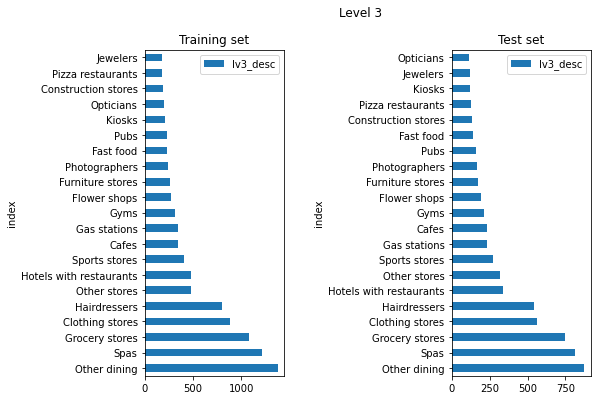

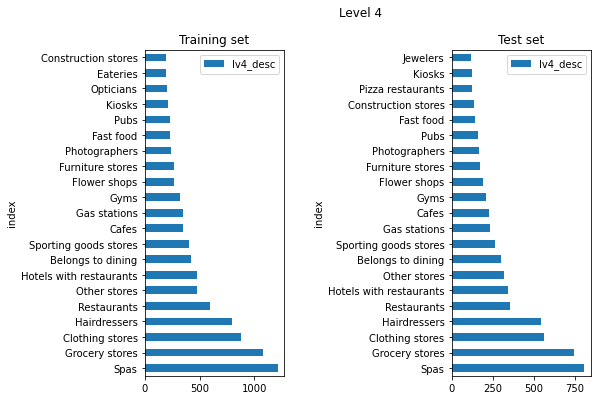

In [40]:
fig, (ax1,ax2) = plt.subplots(figsize=(8,6),ncols=2)
plt.subplots_adjust(wspace=1.2)
plt.suptitle('Level 3')
stores_with_hierarchy.lv3_desc.value_counts().reset_index().truncate(after=20).set_index('index').plot(kind='barh',ax=ax1)
ax1.set_title('Training set')
test_stores_with_hierarchy.lv3_desc.value_counts().reset_index().truncate(after=20).set_index('index').plot(kind='barh',ax=ax2)
ax2.set_title('Test set')
fig, (ax1,ax2) = plt.subplots(figsize=(8,6),ncols=2)
plt.subplots_adjust(wspace=1.2)
plt.suptitle('Level 4')
stores_with_hierarchy.lv4_desc.value_counts().reset_index().truncate(after=20).set_index('index').plot(kind='barh',ax=ax1)
ax1.set_title('Training set')
test_stores_with_hierarchy.lv4_desc.value_counts().reset_index().truncate(after=20).set_index('index').plot(kind='barh',ax=ax2)
ax2.set_title('Test set')

### Anova

In [41]:
anova = ols('revenue ~ lv1+lv2+lv3+lv4',data=stores_with_hierarchy).fit()
sm.stats.anova_lm(anova, typ=2)

sum_sq       df          F    PR(>F)
lv3       1.058575e+06     84.0  78.517917  0.000000
lv4       1.068508e+06     90.0  73.971029  0.000000
lv1       1.689408e+02      1.0   1.052594  0.304930
lv2       1.872210e+02      1.0   1.166490  0.280144
Residual  2.049256e+06  12768.0        NaN       NaN

Level 1 and level 2 have a p-value aroun 0.3.
Level 3 and level 4 have a p-value of 0.0.

Accept the null hypothesis for level 1 and 2, reject for level 3 and 4, with a level of 95%.

### Plaace hierarchy and revenue category

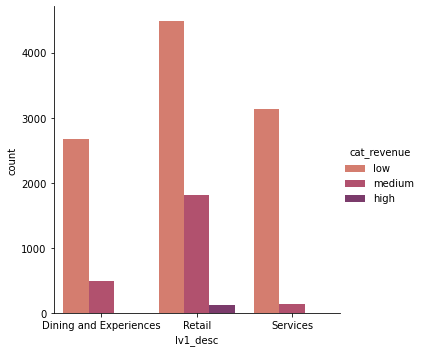

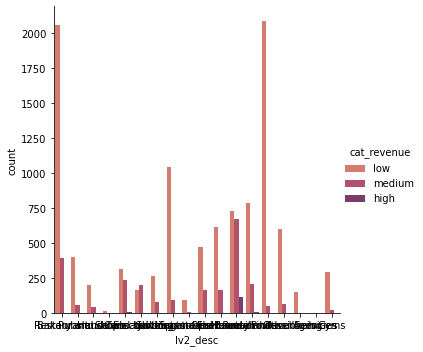

In [42]:
sns.catplot(data=stores_with_hierarchy, x="lv1_desc", hue="cat_revenue", kind="count", palette="flare")
sns.catplot(data=stores_with_hierarchy, x="lv2_desc", hue="cat_revenue", kind="count", palette="flare")

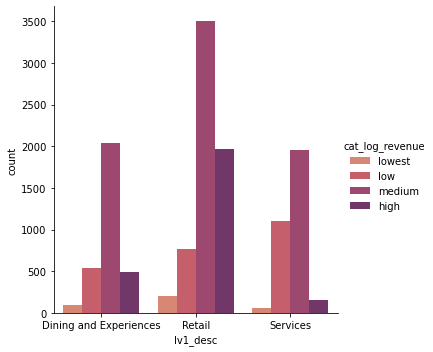

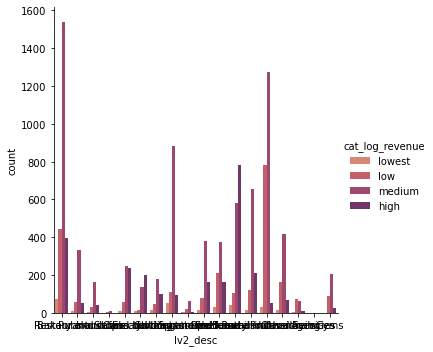

In [43]:
sns.catplot(data=stores_with_hierarchy, x="lv1_desc", hue="cat_log_revenue", kind="count", palette="flare")
sns.catplot(data=stores_with_hierarchy, x="lv2_desc", hue="cat_log_revenue", kind="count", palette="flare")

## Grunnkrets geometry

In [44]:
import geopandas as gpd

In [46]:
geometry_data = grunnkrets[['municipality_name','grunnkrets_name','geometry']]
gs = gpd.GeoSeries.from_wkt(geometry_data['geometry'])
gdf = gpd.GeoDataFrame(geometry_data, geometry=gs, crs="EPSG:4326")

In [47]:
gs = gs.envelope
gdf = gpd.GeoDataFrame(geometry_data, geometry=gs, crs="EPSG:4326")
gdf

municipality_name        grunnkrets_name  \
0          Kristiansand     Fidjane-Vestheiene   
1          Kristiansand       Gimlekollen vest   
2          Kristiansand                   Ryen   
3          Kristiansand             Hånes vest   
4          Kristiansand  Hånes Nord-Bjørndalen   
...                 ...                    ...   
13261             Risør            Risør kirke   
13262          Grimstad                 Ruaker   
13263           Arendal               Løddesøl   
13264           Arendal              Nyli nord   
13265   Evje og Hornnes               Syrtveit   

                                                geometry  
0      POLYGON ((7.91176 58.14035, 7.93865 58.14035, ...  
1      POLYGON ((8.00951 58.16679, 8.02863 58.16679, ...  
2      POLYGON ((8.09104 58.21188, 8.11358 58.21188, ...  
3      POLYGON ((8.07331 58.16756, 8.09623 58.16756, ...  
4      POLYGON ((8.08302 58.17415, 8.09973 58.17415, ...  
...                                                  ...  
13261  POLYGON ((9.22769 58.72023, 9.23265 58.72023, ...  
13262  POLYGON ((8.69979 58.37766, 8.71291 58.37766, ...  
13263  POLYGON ((8.60637 58.42978, 8.64101 58.42978, ...  
13264  POLYGON ((8.76997 58.47465, 8.77882 58.47465, ...  
13265  POLYGON ((7.80460 58.60217, 7.83407 58.60217, ...  

[13266 rows x 3 columns]

Plot of the grunnkrets and thei boundaries

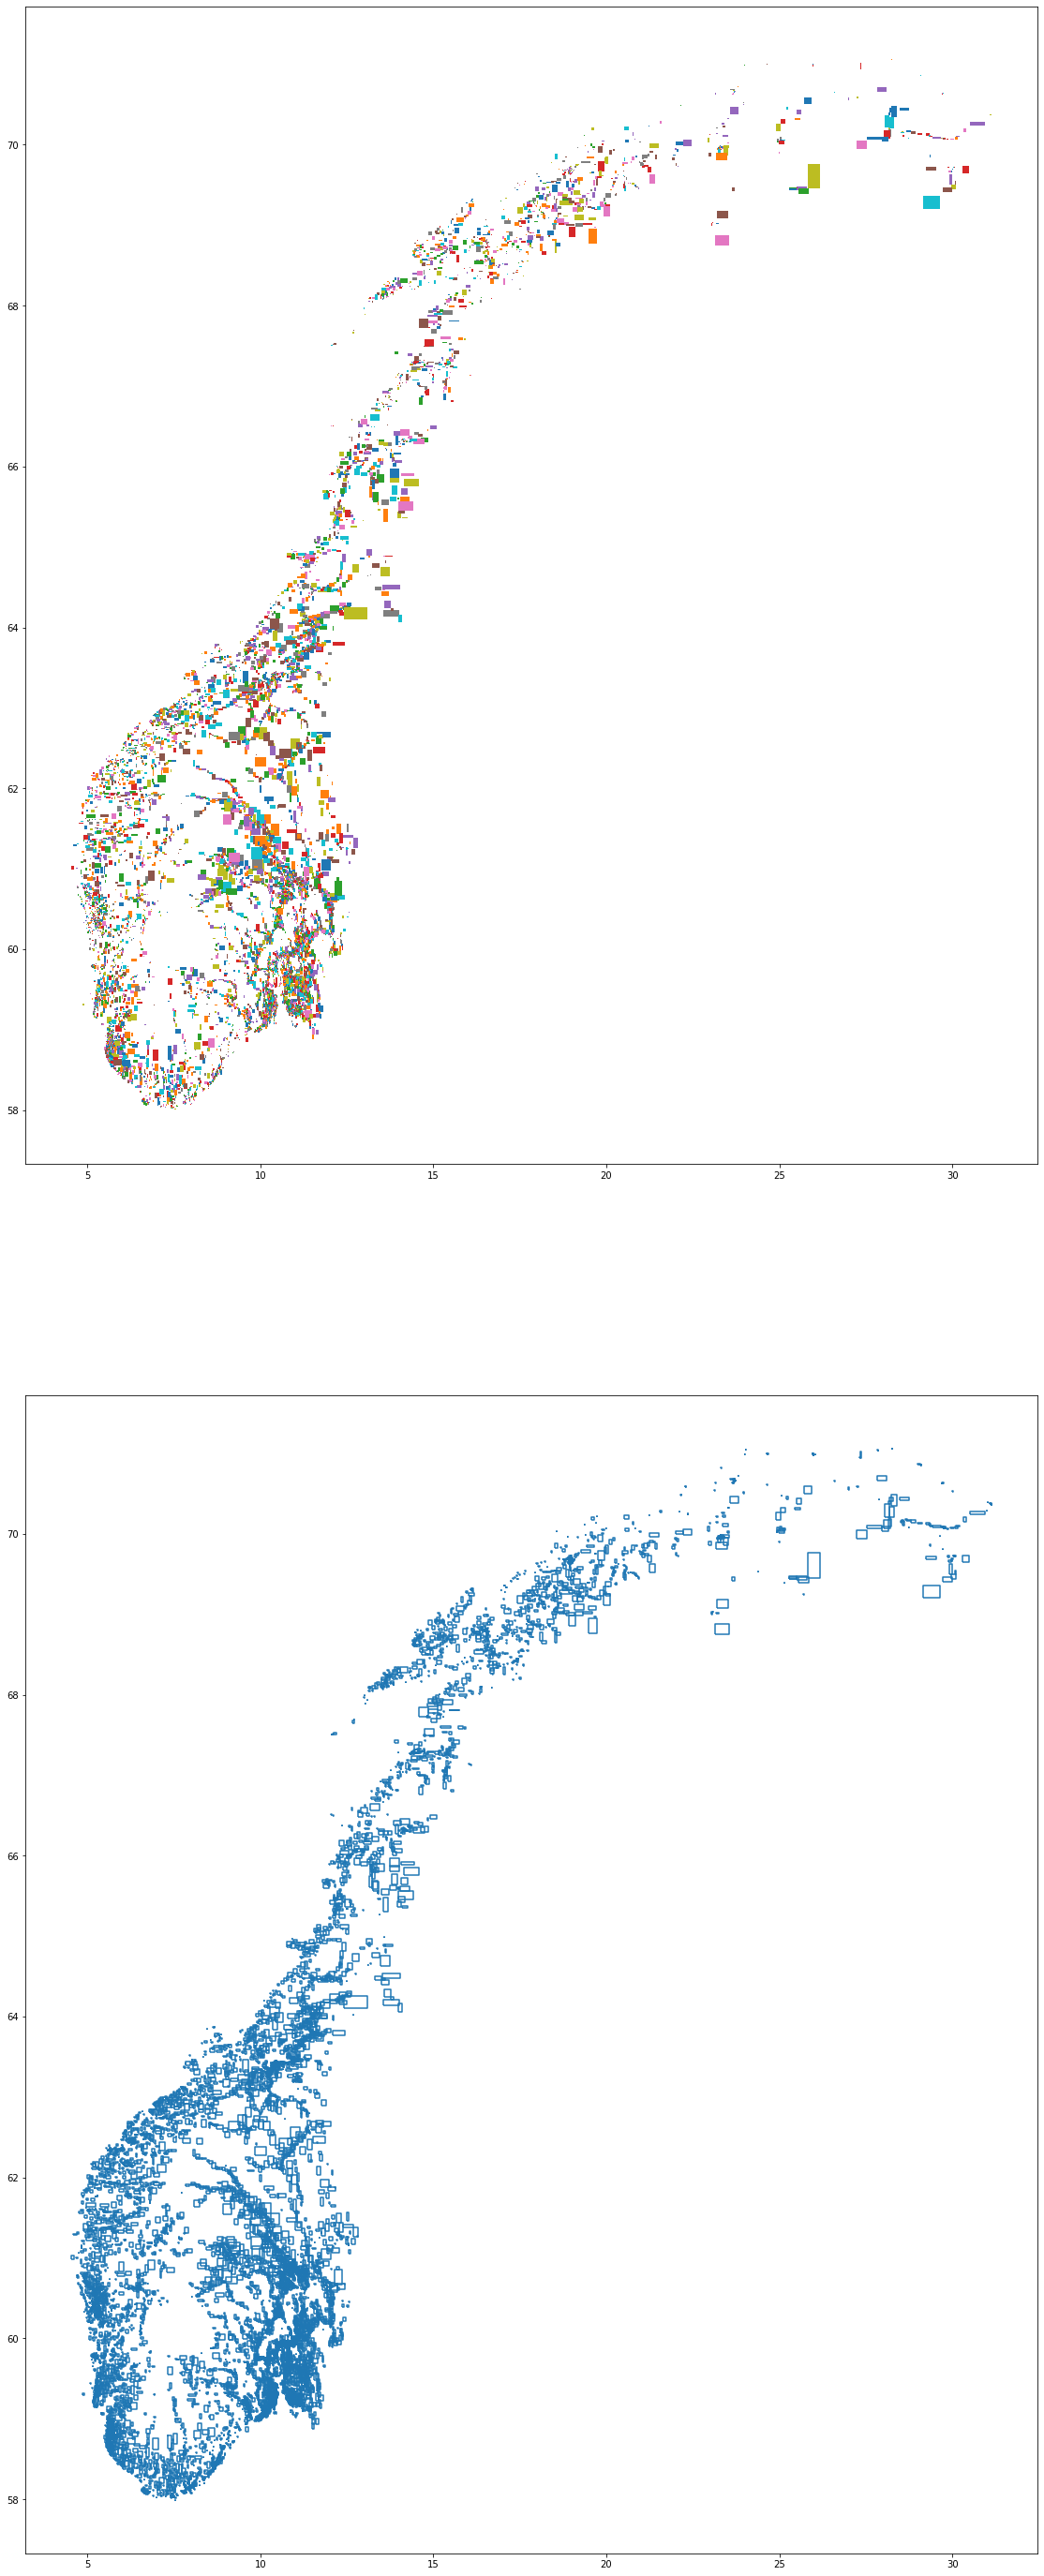

In [48]:
fig, (ax1,ax2) = plt.subplots(figsize=(50,50),nrows=2)
gdf.plot(column='grunnkrets_name',ax=ax1)
gdf.boundary.plot(ax=ax2)

Plot of the municipality and their boundaries

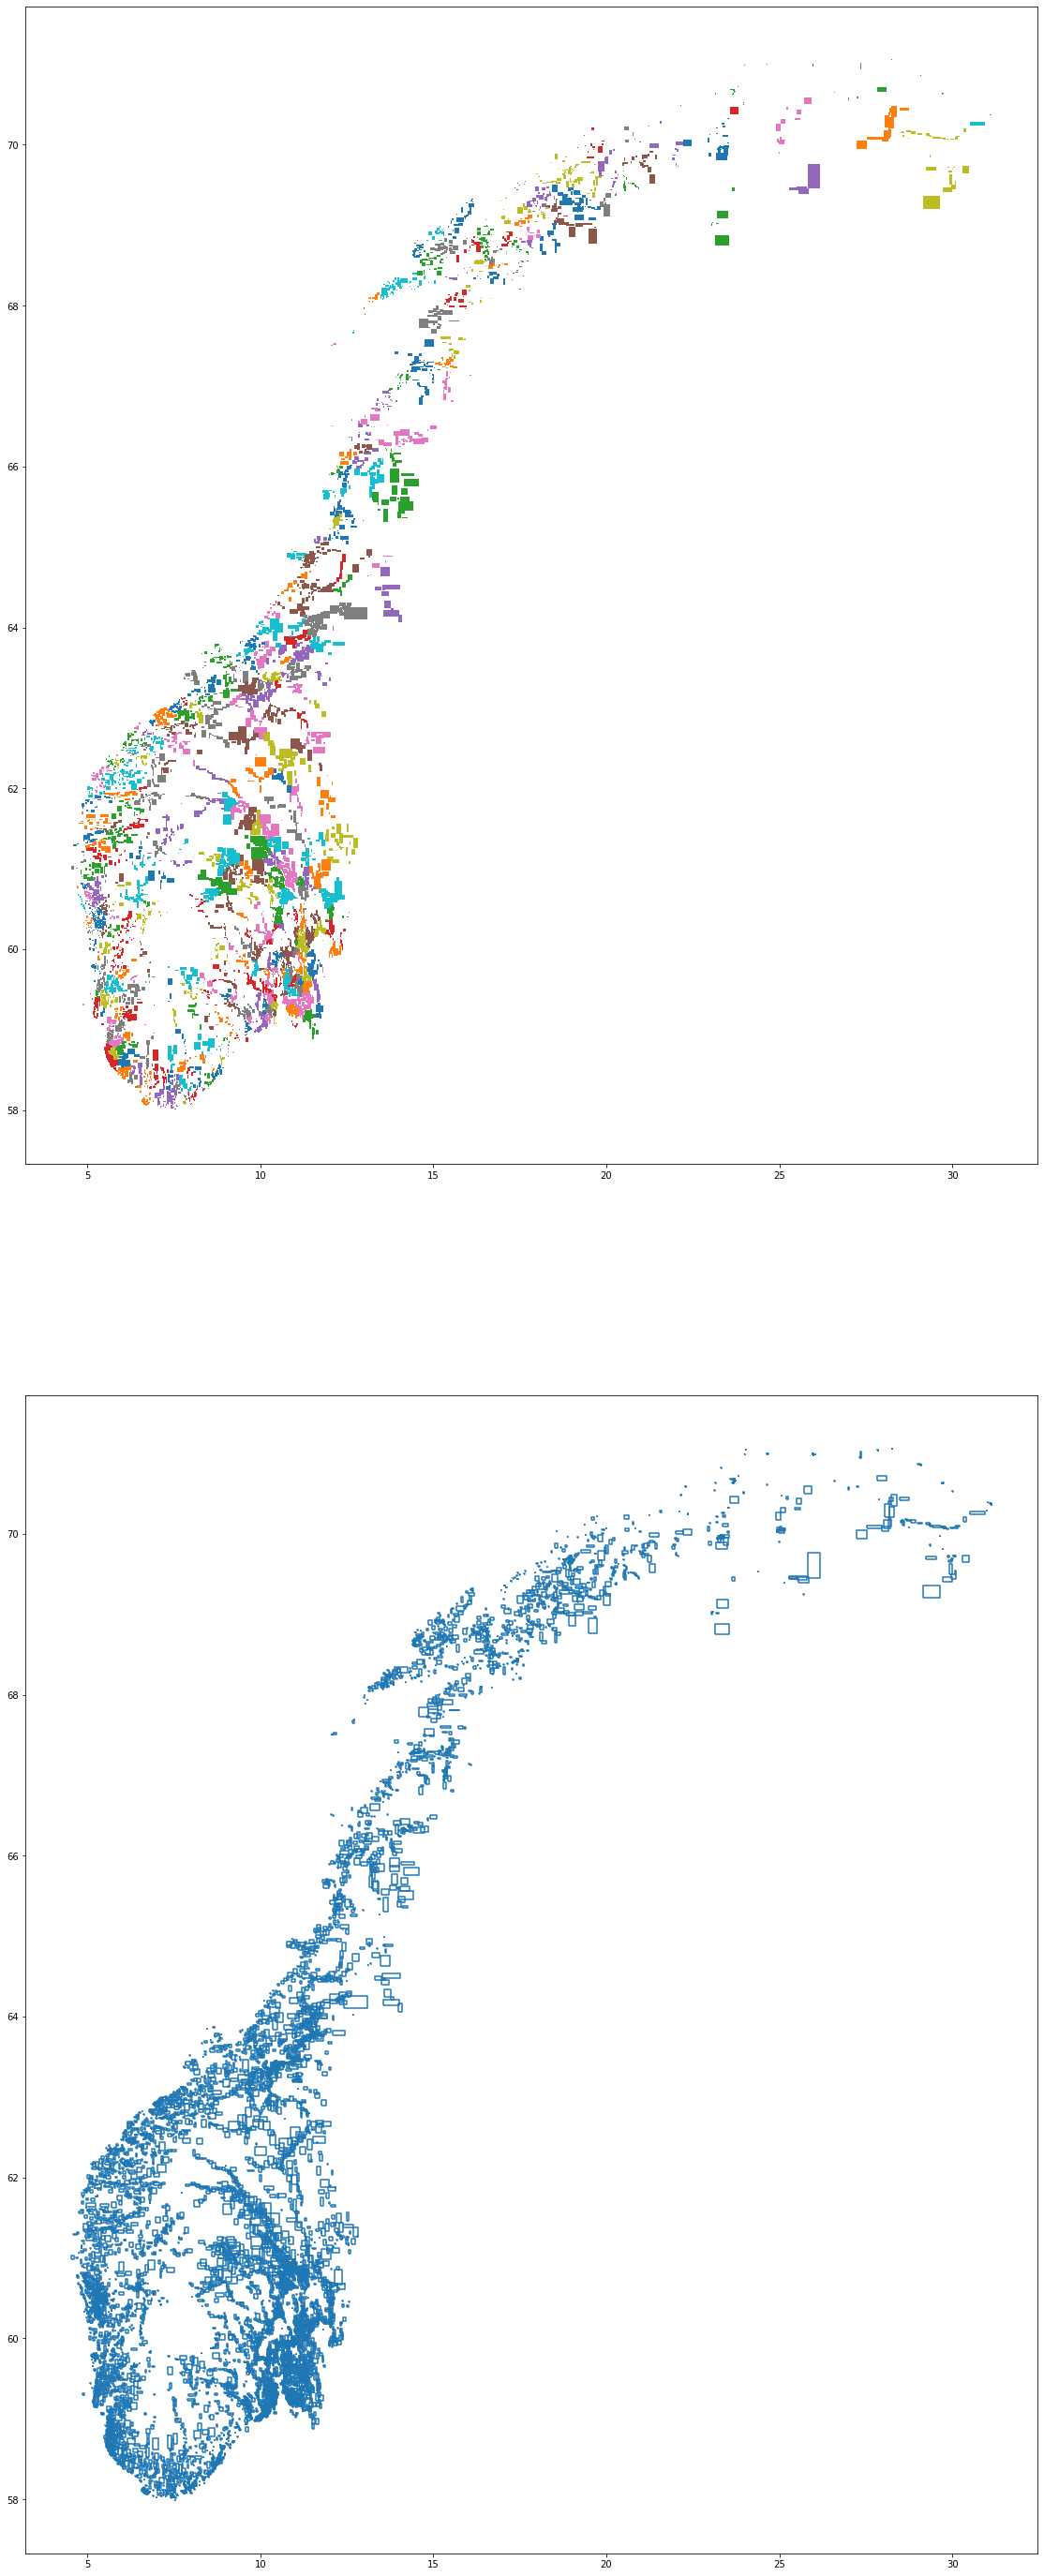

In [49]:
fig, (ax1,ax2) = plt.subplots(figsize=(50,50),nrows=2)
gdf.plot(column='municipality_name',ax=ax1)
gdf.boundary.plot(ax=ax2)

(array([2.707e+03, 2.196e+03, 1.299e+03, 8.390e+02, 7.160e+02, 5.730e+02,
        5.200e+02, 4.220e+02, 3.460e+02, 3.440e+02, 2.940e+02, 3.070e+02,
        2.500e+02, 2.560e+02, 2.180e+02, 1.770e+02, 1.480e+02, 1.510e+02,
        1.390e+02, 1.170e+02, 1.040e+02, 1.090e+02, 1.090e+02, 7.600e+01,
        6.900e+01, 7.800e+01, 5.500e+01, 6.400e+01, 4.700e+01, 5.100e+01,
        4.600e+01, 4.100e+01, 3.100e+01, 3.300e+01, 2.600e+01, 2.300e+01,
        2.600e+01, 2.700e+01, 2.200e+01, 2.200e+01, 1.500e+01, 8.000e+00,
        1.200e+01, 1.100e+01, 1.400e+01, 1.200e+01, 1.100e+01, 9.000e+00,
        8.000e+00, 8.000e+00, 8.000e+00, 4.000e+00, 3.000e+00, 5.000e+00,
        4.000e+00, 7.000e+00, 4.000e+00, 7.000e+00, 5.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        3.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

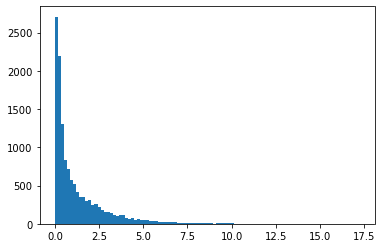

In [50]:
plt.hist(grunnkrets.area_km2_grunnkrets,100)

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,   1.,
          1.,   0.,   1.,   1.,   0.,   3.,   3.,   0.,   1.,   0.,   2.,
          1.,   1.,   1.,   4.,   3.,   2.,   2.,   1.,   4.,   4.,   7.,
          5.,   5.,   4.,   6.,  12.,   8.,   9.,   8.,   7.,  11.,   8.,
         14.,  15.,  22.,  31.,  56.,  59.,  86.,  96., 126., 138., 138.,
        199., 222., 243., 306., 403., 488., 511., 517., 543., 512., 528.,
        480., 556., 449., 517., 534., 517., 533., 489., 535., 535., 545.,
        461., 408., 387., 286., 243., 152., 111.,  73.,  40.,  16.,   6.,
          6.]),
 array([-13.52062863, -13.3569566 , -13.19328456, -13.02961253,
        -12.86594049, -12.70226846, -12.53859642, -12.37492439,
        -12.21125235, -12.04758032, -11.88390828, -11.72023625,
        -11.55656422, -11.39289218, -11.22922015, -11.06554811,
        -10.90187608, -10.73820404, -10.57453201, -10.41085997

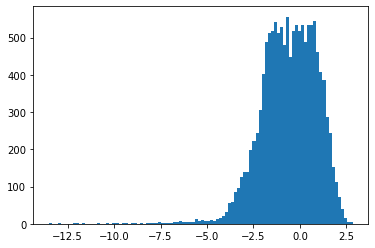

In [51]:
plt.hist(np.log(grunnkrets.area_km2_grunnkrets),100)

The distribution of the grunnkrets seems reasonable. The closer they are to big cities(Oslo, Bergen, etc.), the smaller they become, due to people living more densly packed. In rural areas, they are significantly larger. Plotting them out also gives the shape of Norway, which is to be expected of a comprehensive list of grunnkretses.
The range of the grunnkrets sizes can be explained through more or less dense areas in Norway. However the smalles Grunnkrets seem sometimes unreasonably small, whicht the smallest beeing only a few sqare meters big.

## Stores with grunnkrets

In [52]:
stores_with_grunnkrets = stores_train.merge(grunnkrets,how='left', on='grunnkrets_id')
test_stores_with_grunnkrets = stores_test.merge(grunnkrets,how='left', on='grunnkrets_id')

### Category area and category revenue

Area grunnkrets and revenue

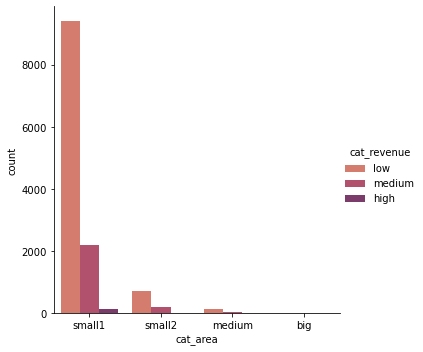

In [53]:
sns.catplot(data=stores_with_grunnkrets, x="cat_area", hue="cat_revenue", kind="count", palette="flare")

Area municipality and revenue

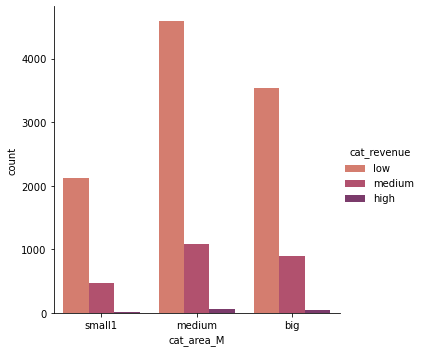

In [54]:
sns.catplot(data=stores_with_grunnkrets, x="cat_area_M", hue="cat_revenue", kind="count", palette="flare")

Area grunnkrets and log revenue

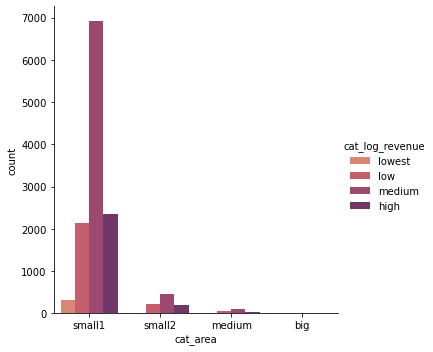

In [55]:
sns.catplot(data=stores_with_grunnkrets, x="cat_area", hue="cat_log_revenue", kind="count", palette="flare")

Area municipality and log revenue

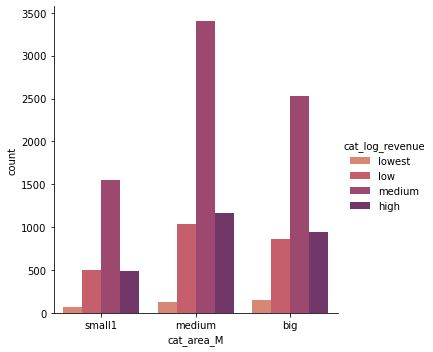

In [56]:
sns.catplot(data=stores_with_grunnkrets, x="cat_area_M", hue="cat_log_revenue", kind="count", palette="flare")

### Correlation area and revenue

Text(0.5, 1.0, 'Area municipality and log revenue')

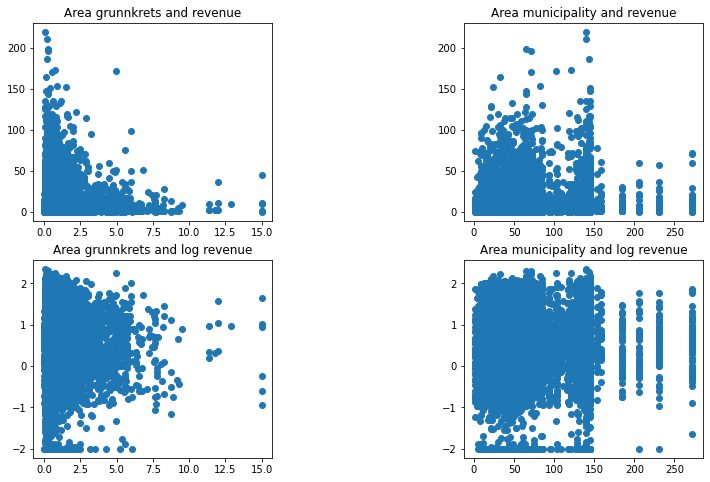

In [57]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(12,8),ncols=2,nrows=2)
plt.subplots_adjust(wspace=0.8)
ax1.scatter(stores_with_grunnkrets.area_km2_grunnkrets,stores_with_grunnkrets.revenue)
ax1.set_title('Area grunnkrets and revenue')
ax2.scatter(stores_with_grunnkrets.area_km2_municipality,stores_with_grunnkrets.revenue)
ax2.set_title('Area municipality and revenue')
ax3.scatter(stores_with_grunnkrets.area_km2_grunnkrets,stores_with_grunnkrets.log_revenue)
ax3.set_title('Area grunnkrets and log revenue')
ax4.scatter(stores_with_grunnkrets.area_km2_municipality,stores_with_grunnkrets.log_revenue)
ax4.set_title('Area municipality and log revenue')

## Grunnkrets ages

Text(0.5, 0, '')

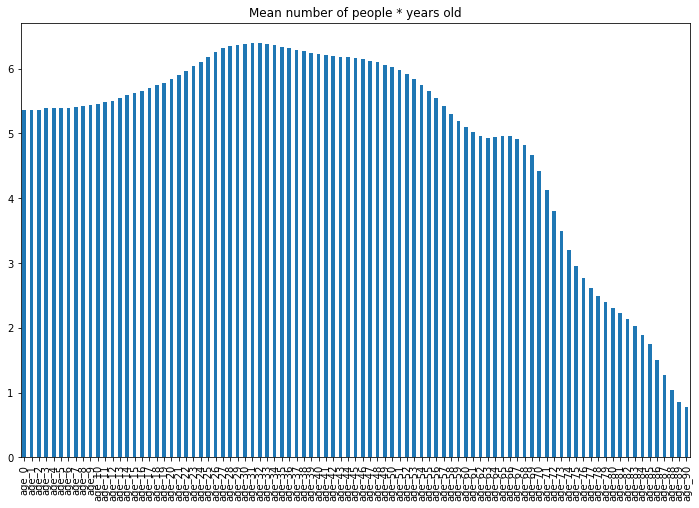

In [58]:
fig, ax1 = plt.subplots(figsize=(12,8))
pop.mean().plot.bar(ax=ax1)
ax1.set_title('Mean number of people * years old')
ax1.set_xlabel(None)

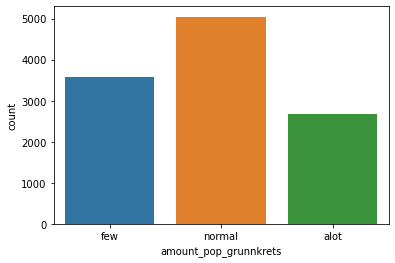

In [59]:
sns.countplot(data=grunnkrets_ages,x='amount_pop_grunnkrets')

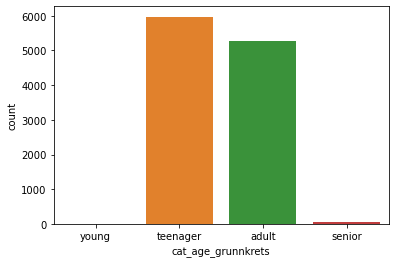

In [60]:
sns.countplot(data=grunnkrets_ages,x='cat_age_grunnkrets')

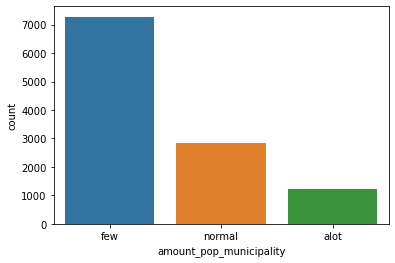

In [61]:
sns.countplot(data=grunnkrets_ages,x='amount_pop_municipality')

## Stores and grunnkrets ages

In [62]:
stores_with_ages = stores_train.merge(grunnkrets_ages,how='left', on='grunnkrets_id')
test_stores_with_ages = stores_test.merge(grunnkrets_ages,how='left', on='grunnkrets_id')

Amount population grunnkrets and revenue category

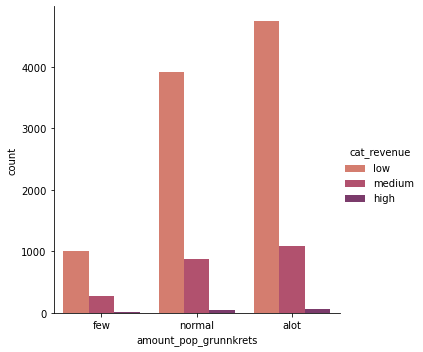

In [63]:
sns.catplot(data=stores_with_ages, x="amount_pop_grunnkrets", hue="cat_revenue", kind="count", palette="flare")

Amount population grunnkrets and log revenue category

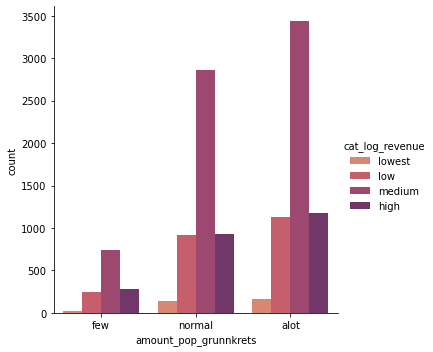

In [64]:
sns.catplot(data=stores_with_ages, x="amount_pop_grunnkrets", hue="cat_log_revenue", kind="count", palette="flare")

Amount population municipality and revenue category

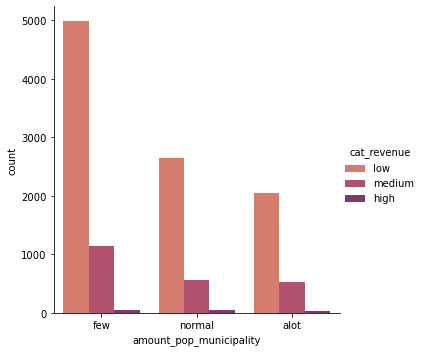

In [65]:
sns.catplot(data=stores_with_ages, x="amount_pop_municipality", hue="cat_revenue", kind="count", palette="flare")

Amount population municipality and log revenue category

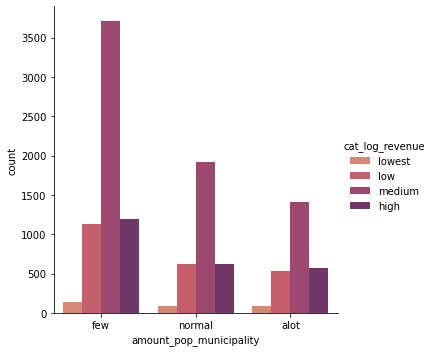

In [66]:
sns.catplot(data=stores_with_ages, x="amount_pop_municipality", hue="cat_log_revenue", kind="count", palette="flare")

Category age and cat revenue

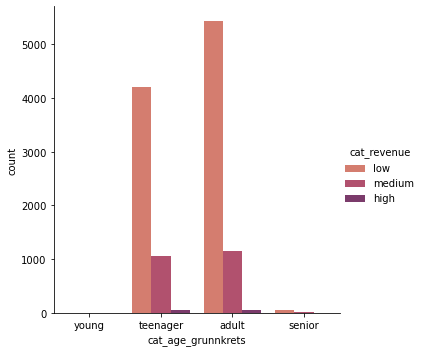

In [67]:
sns.catplot(data=stores_with_ages, x="cat_age_grunnkrets", hue="cat_revenue", kind="count", palette="flare")

Category age and cat log revenue

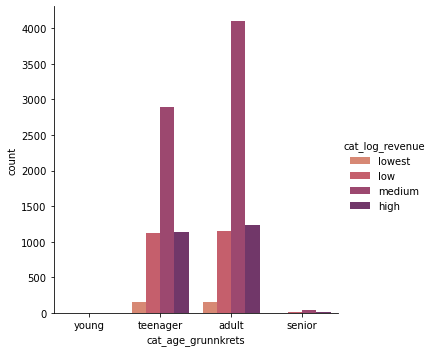

In [68]:
sns.catplot(data=stores_with_ages, x="cat_age_grunnkrets", hue="cat_log_revenue", kind="count", palette="flare")

## Grunnkrets household income

The grunnkrets income has a multitude of entries where the values where equal to zero. This resulted in a pile of outliers at 0 within the otherwise well distributed data set. To adress this issue the following code was run.
This code caluculates the missing values by assinging a scaling factor to each income category based on the existing data. In cases where a income was zero it was replaced by the average income (all_households) scaled by its respective factor.

In [70]:
#Filling in the fields with no all households
i = 'couple_without_children'
factor = grunnkrets_household_income[i].loc[(grunnkrets_household_income[i]>0)&(grunnkrets_household_income.all_households>0)].sum() /\
            grunnkrets_household_income.all_households[grunnkrets_household_income[i]>0].sum()
for kk in range(len(grunnkrets_household_income)):
        if grunnkrets_household_income.all_households.iloc[kk] == 0:
            grunnkrets_household_income.all_households.iloc[kk] = factor*grunnkrets_household_income[i].iloc[kk]
            
        if grunnkrets_household_income[i].iloc[kk] == 0:
            grunnkrets_household_income[i].iloc[kk] = factor*grunnkrets_household_income.all_households.iloc[kk]


counter_names = ['singles','couple_with_children','other_households','single_parent_with_children']

#filling the other fields based on a factor and all households
for i in counter_names:
    factor = grunnkrets_household_income[i][grunnkrets_household_income[i]>0].sum()/\
        grunnkrets_household_income.all_households[grunnkrets_household_income[i]>0].sum()
    #print(factor)
    for jj in range(len(grunnkrets_household_income)):
        if grunnkrets_household_income[i].iloc[jj] == 0:
            grunnkrets_household_income[i].iloc[jj] = factor*grunnkrets_household_income.all_households.iloc[jj]
    

C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [25]:
'''
null_singles = grunnkrets_household_income.loc[grunnkrets_household_income.singles==0] 
null_singles['singles'] = np.nan
grunnkrets_household_income.loc[grunnkrets_household_income.singles==0] = null_singles

null_couple_without_children = grunnkrets_household_income[grunnkrets_household_income.couple_without_children==0]
null_couple_without_children['couple_without_children'] = np.nan
grunnkrets_household_income[grunnkrets_household_income.couple_without_children==0] = null_couple_without_children

null_couple_with_children = grunnkrets_household_income[grunnkrets_household_income.couple_with_children==0]
null_couple_with_children['couple_with_children'] = np.nan
grunnkrets_household_income[grunnkrets_household_income.couple_with_children==0] = null_couple_with_children

null_other_households = grunnkrets_household_income[grunnkrets_household_income.other_households==0] 
null_other_households['other_households'] = np.nan
grunnkrets_household_income[grunnkrets_household_income.other_households==0] = null_other_households

null_single_parent_with_children = grunnkrets_household_income[grunnkrets_household_income.single_parent_with_children==0]
null_single_parent_with_children['single_parent_with_children'] = np.nan
grunnkrets_household_income[grunnkrets_household_income.single_parent_with_children==0] = null_single_parent_with_children

null_all_households = grunnkrets_household_income.loc[grunnkrets_household_income.all_households==0]
null_all_households['all_households'] = np.nan
grunnkrets_household_income[grunnkrets_household_income.all_households==0] = null_all_households
'''

C:\Users\Noname\AppData\Local\Temp\ipykernel_22548\2723503352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_singles['singles'] = np.nan
C:\Users\Noname\AppData\Local\Temp\ipykernel_22548\2723503352.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_couple_with_children['couple_with_children'] = np.nan
C:\Users\Noname\AppData\Local\Temp\ipykernel_22548\2723503352.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

### Pairplot income

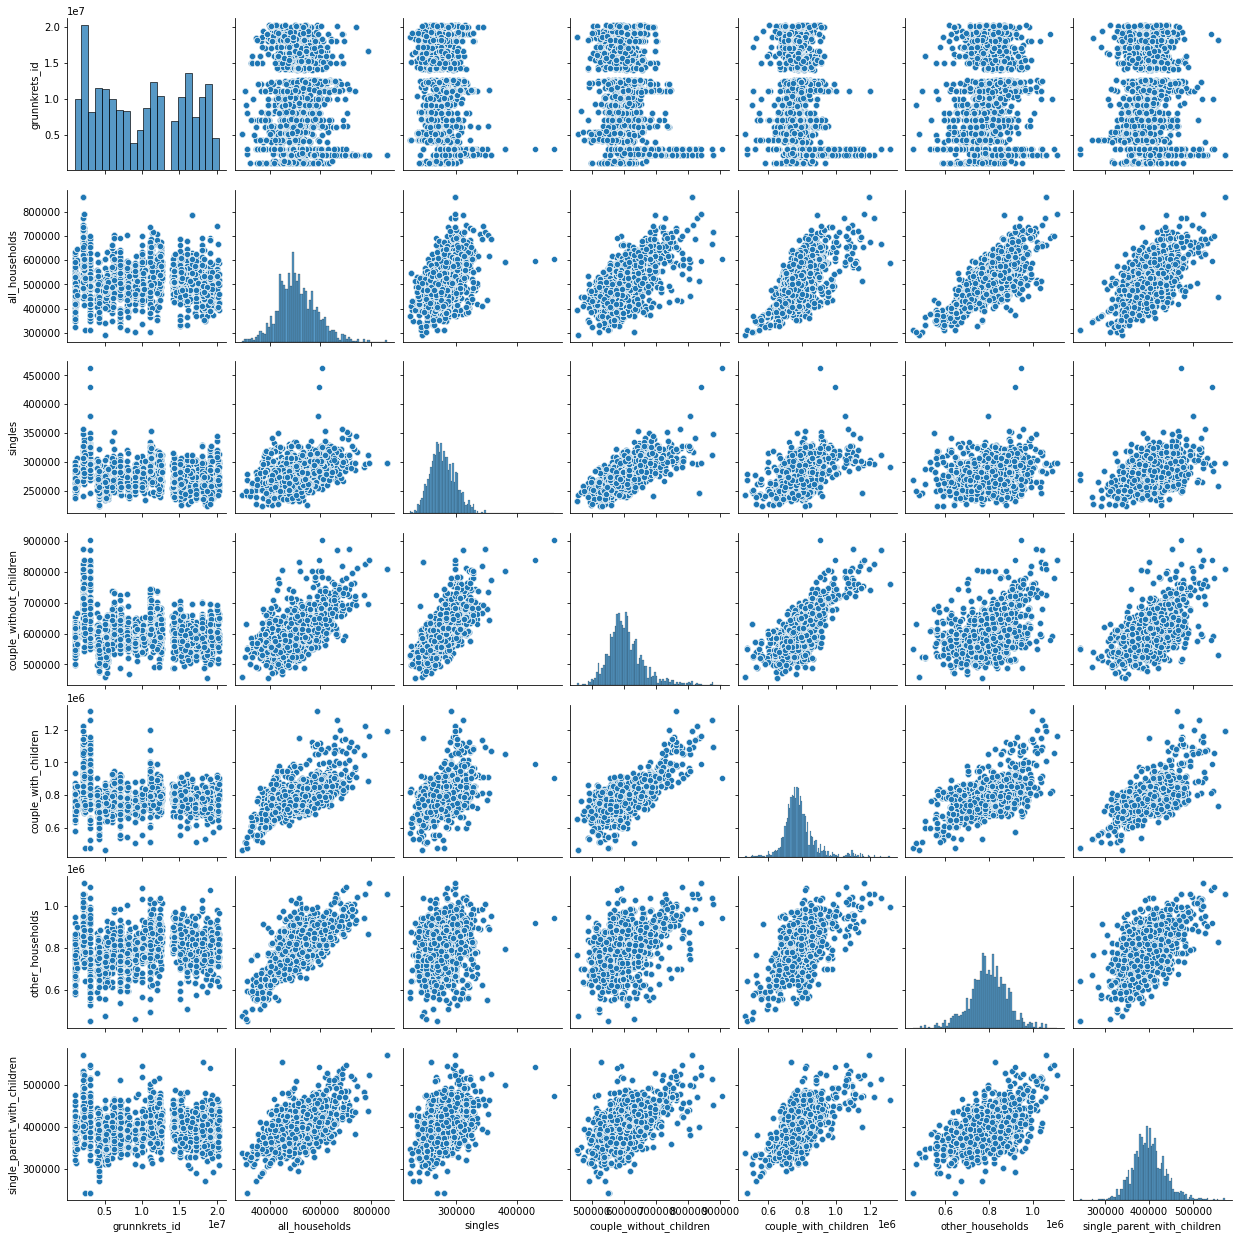

In [86]:
sns.pairplot(grunnkrets_household_income)

## Fill the nan

Some of the stores provided in the data did belong to any of the grunnkrets that the were provided as well. To fill in the Nans in the features that rely on the grunnkrets information such as demographic and income data, the following code was implemented.

In [82]:
df_nan = pd.concat([stores_train.drop(columns=['revenue','cat_revenue','cat_log_revenue','log_revenue']),stores_test],ignore_index=True)
df_nan = pd.concat([df_nan,stores_extra], ignore_index=True)

In [83]:
df_nan = df_nan.merge(grunnkrets,how='left',on='grunnkrets_id')

Assign to the stores with nan value the grunnkrets geometry values of the closest stores

In [84]:
def getDistance(lat_1,lon_1,lat_2,lon_2):
    r = 6371 #radius of Earth (KM)
    p = np.pi/180 # helper variable for calculation
    #formula based on Wikipedia https://en.wikipedia.org/wiki/Haversine_formula
    #Formaua is potentially calculation intensive
    a = 0.5 - np.cos((lat_2-lat_1)*p)/2 + np.cos(lat_1*p)*np.cos(lat_2*p) * (1-np.cos((lon_2-lon_1)*p)) / 2
    distance = 2 * r * np.arcsin(np.sqrt(a)) #2*R*asin
    return distance


### Grunnkrets

In [85]:
treshold_distance = 1
nan_index = df_nan.index[df_nan.grunnkrets_name.isna()]
nan_index = [x for x in nan_index if x <= len(stores_train)+len(stores_test)]
for n in nan_index :
    min_dist=1000
    for k in range(len(df_nan)):
        dist = getDistance(df_nan.lat.iloc[n],df_nan.lon.iloc[n],
                df_nan.lat.iloc[k],df_nan.lon.iloc[k])
        if (dist<min_dist and df_nan.grunnkrets_name.isna()[k]==False):
            min_dist=dist
            index=k
        if (dist < treshold_distance and k!=n and df_nan.grunnkrets_name.isna()[k] == False):
            df_nan.grunnkrets_name[n] = df_nan.grunnkrets_name[k]
            df_nan.district_name[n] = df_nan.district_name[k]
            df_nan.municipality_name[n] = df_nan.municipality_name[k]
            df_nan.geometry[n] = df_nan.geometry[k]
            df_nan.lon_centroid[n] = df_nan.lon_centroid[k]
            df_nan.lat_centroid[n] = df_nan.lat_centroid[k]
            df_nan.area_km2_grunnkrets[n] = df_nan.area_km2_grunnkrets[k]
            df_nan.area_km2_municipality[n] = df_nan.area_km2_municipality[k]
            df_nan.cat_area[n] = df_nan.cat_area[k]
            df_nan.cat_area_M[n] = df_nan.cat_area_M[k]
            break
        if (k==len(df_nan)-1):
            df_nan.grunnkrets_name[n] = df_nan.grunnkrets_name[index]
            df_nan.district_name[n] = df_nan.district_name[index]
            df_nan.municipality_name[n] = df_nan.municipality_name[index]
            df_nan.geometry[n] = df_nan.geometry[index]
            df_nan.lon_centroid[n] = df_nan.lon_centroid[index]
            df_nan.lat_centroid[n] = df_nan.lat_centroid[index]
            df_nan.area_km2_grunnkrets[n] = df_nan.area_km2_grunnkrets[index]
            df_nan.area_km2_municipality[n] = df_nan.area_km2_municipality[index]
            df_nan.cat_area[n] = df_nan.cat_area[index]
            df_nan.cat_area_M[n] = df_nan.cat_area_M[index]

C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launche

In [86]:
df_nan = df_nan.merge(grunnkrets_household_income,how='left',on='grunnkrets_id')

### Grunnkrets income

In [87]:
nan_index = df_nan.index[df_nan.all_households.isna()]
nan_index = [x for x in nan_index if x <= len(stores_train)+len(stores_test)]
for n in nan_index:
    for k in df_nan.index[df_nan.grunnkrets_name==df_nan.grunnkrets_name[n]]:
        if(k!=n):
            df_nan.all_households[n] = df_nan.all_households[k]
            df_nan.singles[n] = df_nan.singles[k]
            df_nan.couple_without_children[n] = df_nan.couple_without_children[k]
            df_nan.couple_with_children[n] = df_nan.couple_with_children[k]
            df_nan.other_households[n] = df_nan.other_households[k]
            df_nan.single_parent_with_children[n] = df_nan.single_parent_with_children[k]
            break
nan_index = df_nan.index[df_nan.all_households.isna()]
nan_index = [x for x in nan_index if x <= len(stores_train)+len(stores_test)]
for n in nan_index:
    min_dist=1000
    for k in range(len(df_nan)):
        dist = getDistance(df_nan.lat.iloc[n],df_nan.lon.iloc[n],
                df_nan.lat.iloc[k],df_nan.lon.iloc[k])
        if (dist<min_dist and df_nan.all_households.isna()[k] == False):
            min_dist = dist
            index=k
        if (dist < treshold_distance and k!=n and df_nan.all_households.isna()[k] == False) :
            df_nan.all_households[n] = df_nan.all_households[k]
            df_nan.singles[n] = df_nan.singles[k]
            df_nan.couple_without_children[n] = df_nan.couple_without_children[k]
            df_nan.couple_with_children[n] = df_nan.couple_with_children[k]
            df_nan.other_households[n] = df_nan.other_households[k]
            df_nan.single_parent_with_children[n] = df_nan.single_parent_with_children[k]
            break
        if (k==len(df_nan)-1):
            df_nan.all_households[n] = df_nan.all_households[index]
            df_nan.singles[n] = df_nan.singles[index]
            df_nan.couple_without_children[n] = df_nan.couple_without_children[index]
            df_nan.couple_with_children[n] = df_nan.couple_with_children[index]
            df_nan.other_households[n] = df_nan.other_households[index]
            df_nan.single_parent_with_children[n] = df_nan.single_parent_with_children[index]

C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\i

In [88]:
df_nan = df_nan.merge(grunnkrets_ages,how='left',on=['grunnkrets_id','municipality_name'])

In [89]:
nan_index = df_nan.index[df_nan.pop_grunnkrets.isna()]
nan_index = [x for x in nan_index if x <= len(stores_train)+len(stores_test)]
for n in nan_index:
    for k in df_nan.index[df_nan.grunnkrets_name==df_nan.grunnkrets_name[n]]:
        if(k!=n):
            df_nan.pop_grunnkrets[n] = df_nan.pop_grunnkrets[k]
            df_nan.pop_municipality[n] = df_nan.pop_municipality[k]
            df_nan.mean_age[n] = df_nan.mean_age[k]
            df_nan.municipality_name[n] = df_nan.municipality_name[k]
            df_nan.pop_grunnkrets[n] = df_nan.pop_grunnkrets[k]
            df_nan.amount_pop_grunnkrets[n] = df_nan.amount_pop_grunnkrets[k]
            df_nan.cat_age_grunnkrets[n] = df_nan.cat_age_grunnkrets[k]
            df_nan.amount_pop_municipality[n] = df_nan.amount_pop_municipality[k]
            df_nan.pop_0_18[n] = df_nan.pop_0_18[k]
            df_nan.pop_19_36[n] = df_nan.pop_19_36[k]
            df_nan.pop_37_54[n] = df_nan.pop_37_54[k]
            df_nan.pop_55_72[n] = df_nan.pop_55_72[k]
            df_nan.pop_over_73[n] = df_nan.pop_over_73[k]            
            break
nan_index = df_nan.index[df_nan.pop_grunnkrets.isna()]
nan_index = [x for x in nan_index if x <= len(stores_train)+len(stores_test)]
for n in df_nan.index[df_nan.pop_grunnkrets.isna()]:
    min_dist = 1000
    for k in range(len(df_nan)):
        dist = getDistance(df_nan.lat.iloc[n],df_nan.lon.iloc[n],
                df_nan.lat.iloc[k],df_nan.lon.iloc[k])
        if (dist<min_dist and df_nan.pop_grunnkrets.isna()[k] == False):
            min_dist = dist
            index=k
        if (dist < treshold_distance and k!=n and df_nan.pop_grunnkrets.isna()[k] == False) :
            df_nan.pop_grunnkrets[n] = df_nan.pop_grunnkrets[k]
            df_nan.mean_age[n] = df_nan.mean_age[k]
            df_nan.municipality_name[n] = df_nan.municipality_name[k]
            df_nan.pop_grunnkrets[n] = df_nan.pop_grunnkrets[k]
            df_nan.pop_municipality[n] = df_nan.pop_municipality[k]
            df_nan.amount_pop_grunnkrets[n] = df_nan.amount_pop_grunnkrets[k]
            df_nan.cat_age_grunnkrets[n] = df_nan.cat_age_grunnkrets[k]
            df_nan.amount_pop_municipality[n] = df_nan.amount_pop_municipality[k] 
            df_nan.pop_0_18[n] = df_nan.pop_0_18[k]
            df_nan.pop_19_36[n] = df_nan.pop_19_36[k]
            df_nan.pop_37_54[n] = df_nan.pop_37_54[k]
            df_nan.pop_55_72[n] = df_nan.pop_55_72[k]
            df_nan.pop_over_73[n] = df_nan.pop_over_73[k]    
            break
        if (k==len(df_nan)-1):
            df_nan.pop_grunnkrets[n] = df_nan.pop_grunnkrets[index]
            df_nan.pop_municipality[n] = df_nan.pop_municipality[index]
            df_nan.mean_age[n] = df_nan.mean_age[index]
            df_nan.municipality_name[n] = df_nan.municipality_name[index]
            df_nan.pop_grunnkrets[n] = df_nan.pop_grunnkrets[index]
            df_nan.amount_pop_grunnkrets[n] = df_nan.amount_pop_grunnkrets[index]
            df_nan.cat_age_grunnkrets[n] = df_nan.cat_age_grunnkrets[index]
            df_nan.amount_pop_municipality[n] = df_nan.amount_pop_municipality[index]
            df_nan.pop_0_18[n] = df_nan.pop_0_18[index]
            df_nan.pop_19_36[n] = df_nan.pop_19_36[index]
            df_nan.pop_37_54[n] = df_nan.pop_37_54[index]
            df_nan.pop_55_72[n] = df_nan.pop_55_72[index]
            df_nan.pop_over_73[n] = df_nan.pop_over_73[index]

C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\i

In [90]:
df_nan = df_nan.merge(grunnkrets_household_types,how='left',on=['grunnkrets_id'])

In [92]:
df_nan.rename(columns={'couple_without_children_y':'couple_without_children_num','singles_y':'singles_num'},inplace=True)
df_nan.rename(columns={'singles_x':'singles','couple_without_children_x':'couple_without_children'},inplace=True)

In [94]:
nan_index = df_nan.index[df_nan.number_household.isna()]
nan_index = [x for x in nan_index if x <= len(stores_train)+len(stores_test)]
for n in nan_index:
    for k in df_nan.index[df_nan.grunnkrets_name==df_nan.grunnkrets_name[n]]:
        if(k!=n):
            df_nan.number_household[n] = df_nan.number_household[k]
            df_nan.singles_num[n] = df_nan.singles_num[k]
            df_nan.single_parent_children_6_to_17_years[n] = df_nan.single_parent_children_6_to_17_years[k]
            df_nan.single_parent_children_18_or_above[n] = df_nan.single_parent_children_18_or_above[k]
            df_nan.single_parent_children_0_to_5_years[n] = df_nan.single_parent_children_0_to_5_years[k]
            
            df_nan.couple_without_children_num[n] = df_nan.couple_without_children_num[k]
            df_nan.couple_children_6_to_17_years[n] = df_nan.couple_children_6_to_17_years[k]
            df_nan.couple_children_18_or_above[n] = df_nan.couple_children_18_or_above[k]
            df_nan.couple_children_0_to_5_years[n] = df_nan.couple_children_0_to_5_years[k]

            break
nan_index = df_nan.index[df_nan.number_household.isna()]
nan_index = [x for x in nan_index if x <= len(stores_train)+len(stores_test)]
for n in df_nan.index[df_nan.number_household.isna()]:
    min_dist = 1000
    for k in range(len(df_nan)):
        dist = getDistance(df_nan.lat.iloc[n],df_nan.lon.iloc[n],
                df_nan.lat.iloc[k],df_nan.lon.iloc[k])
        if (dist<min_dist and df_nan.number_household.isna()[k] == False):
            min_dist = dist
            index=k
        if (dist < treshold_distance and k!=n and df_nan.number_household.isna()[k] == False) :
            df_nan.number_household[n] = df_nan.number_household[k]
            df_nan.singles_num[n] = df_nan.singles_num[k]
            df_nan.single_parent_children_6_to_17_years[n] = df_nan.single_parent_children_6_to_17_years[k]
            df_nan.single_parent_children_18_or_above[n] = df_nan.single_parent_children_18_or_above[k]
            df_nan.single_parent_children_0_to_5_years[n] = df_nan.single_parent_children_0_to_5_years[k]
            df_nan.couple_without_children_num[n] = df_nan.couple_without_children_num[k]
            df_nan.couple_children_6_to_17_years[n] = df_nan.couple_children_6_to_17_years[k]
            df_nan.couple_children_18_or_above[n] = df_nan.couple_children_18_or_above[k]
            df_nan.couple_children_0_to_5_years[n] = df_nan.couple_children_0_to_5_years[k]
            break
        if (k==len(df_nan)-1):
            df_nan.number_household[n] = df_nan.number_household[index]
            df_nan.singles_num[n] = df_nan.singles_num[index]
            df_nan.mean_age[n] = df_nan.mean_age[index]
            df_nan.single_parent_children_6_to_17_years[n] = df_nan.single_parent_children_6_to_17_years[index]
            df_nan.single_parent_children_18_or_above[n] = df_nan.single_parent_children_18_or_above[index]
            df_nan.single_parent_children_0_to_5_years[n] = df_nan.single_parent_children_0_to_5_years[index]
            df_nan.couple_without_children_num[n] = df_nan.couple_without_children_num[index]
            df_nan.couple_children_6_to_17_years[n] = df_nan.couple_children_6_to_17_years[index]
            df_nan.couple_children_18_or_above[n] = df_nan.couple_children_18_or_above[index]
            df_nan.couple_children_0_to_5_years[n] = df_nan.couple_children_0_to_5_years[index]

C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\i

In [95]:
df_nan = df_nan.merge(plaace_hierarchy,how='left',on=['plaace_hierarchy_id','sales_channel_name'])

In [333]:
df = df_nan[:len(stores_train)+len(stores_test)]

## Feature engineering

In [100]:
def getDistance(lat_1,lon_1,lat_2,lon_2):
    r = 6371 #radius of Earth (KM)
    p = np.pi/180 # helper variable for calculation
    #formula based on Wikipedia https://en.wikipedia.org/wiki/Haversine_formula
    #Formaua is potentially calculation intensive
    a = 0.5 - np.cos((lat_2-lat_1)*p)/2 + np.cos(lat_1*p)*np.cos(lat_2*p) * (1-np.cos((lon_2-lon_1)*p)) / 2
    distance = 2 * r * np.arcsin(np.sqrt(a)) #2*R*asin
    return distance

In [101]:
def get_cartesian(lat=None,lon=None):
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    R = 6371 # radius of the earth
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)
    pos = np.array([x,y,z])
    return pos

### Grunnkrets household income
mean income
category for income base on type of households

In [298]:
df['mean_income'] = df[['singles','couple_without_children','couple_with_children',
                                                                         'other_households','single_parent_with_children']].mean(axis=1)
df['sum_income'] = df[['singles','couple_without_children','couple_with_children',
                                                                         'other_households','single_parent_with_children']].sum(axis=1)
df['cat_income'] = pd.cut(df['mean_income'],bins=3,labels=['poor','good','rich'])

df['cat_single'] = pd.cut(df['singles'],bins=3,labels=['poorS','goodS','richS'])
df['cat_all_households'] = pd.cut(df['all_households'],bins=3,labels=['poorA','goodA','richA'])
df['cat_couple_without_children'] = pd.cut(df['couple_without_children'],bins=3,labels=['poorC','goodC','richC'])
df['cat_couple_with_children'] = pd.cut(df['couple_with_children'], bins=3,labels=['poorCC','goodCC','richCC'])
df['cat_other_households'] = pd.cut(df['other_households'],bins=3,labels=['poorO','goodO','richO'])
df['cat_single_parent_with_children'] = pd.cut(df['single_parent_with_children'],bins=3,labels=['poorSC','goodSC','richSC'])

C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

### Score for bus station
Intuitivly, having a good connection with the public transport could be an advantagous feat for a shop. Additionally the density of bus stations can also indicate how urban or rural an area is. This feature is a numerical value calculated based on the amounts of busstations within a certain area of each shop.

In [97]:
busstops.importance_level[busstops.importance_level=='Mangler viktighetsnivå'] = 0
busstops.importance_level[busstops.importance_level=='Standard holdeplass'] = 1
busstops.importance_level[busstops.importance_level=='Lokalt knutepunkt'] = 2
busstops.importance_level[busstops.importance_level=='Regionalt knutepunkt'] = 3
busstops.importance_level[busstops.importance_level=='Nasjonalt knutepunkt'] = 4
busstops.importance_level[busstops.importance_level=='Annen viktig holdeplass'] = 5

In [334]:
Bus_position = busstops.geometry

placeholder = Bus_position[0]

bus_lat = np.zeros(np.size(Bus_position))
bus_lon = np.zeros(np.size(Bus_position))
for ii in range(np.size(Bus_position)):
    placeholder = Bus_position[ii]
    placeholder = placeholder.replace('POINT(','')
    placeholder = placeholder.replace(')','')
    placeholder = placeholder.split(' ')
    bus_lat[ii]=float(placeholder[1])
    bus_lon[ii]=float(placeholder[0])
    
busstops = busstops.drop(columns=['geometry','busstop_id'])
busstops['lat'] = bus_lat
busstops['lon'] = bus_lon

In [ ]:
InfrastructureScore = np.zeros([len(df),6])
for jj in range(len(df)):
    stationValue = np.zeros(6)
    ShopPos = get_cartesian(df.lat[jj],df.lon[jj])
    for ii in range(len(busstops)):
        BusPos = get_cartesian(busstops.lat[ii],busstops.lon[ii])
        distance = np.linalg.norm(BusPos-ShopPos)
        if distance < 0.3:
            stationValue[busstops.importance_level[ii]] +=1
    InfrastructureScore[jj,:] = stationValue
InfrastructureScore

In [ ]:
buss = pd.DataFrame(InfrastructureScore, columns=['infraScore_1','infraScore_2','infraScore_3','infraScore_4','infraScore_5','infraScore_6'])
df = df.join(buss)
df['infraScore']=df['infraScore_1']+df['infraScore_2']+df['infraScore_3']+df['infraScore_4']+df['infraScore_5']+df['infraScore_6']

### Competitors score
Assign a diffrent score to each stores based on the number of stores, belonging to the same category (same level 3), close to it

In [104]:
df_extra = df.append(stores_extra).reset_index(drop = True)

In [105]:
CompetitorsScore = np.zeros([len(df_extra),2])
for jj in range(len(df)):
    competitorsValue = np.zeros(2)
    ShopPos = get_cartesian(df.lat[jj],df.lon[jj])
    for ii in df_extra[df_extra.lv2_desc==df.lv2_desc[jj]].index:
        CompetitorsPos = get_cartesian(df_extra.lat[ii],df_extra.lon[ii])
        long = np.linalg.norm(ShopPos-CompetitorsPos)
        short = np.linalg.norm(ShopPos-CompetitorsPos)
        if long < 0.2:
            competitorsValue[0] += 1
        if short < 0.05:
            competitorsValue[1] += 1
    CompetitorsScore[jj,:] = competitorsValue

In [106]:
competitors = pd.DataFrame(CompetitorsScore, columns=['Competitors1','Competitors2'])
df = df.join(competitors)

### Chain rank

Assign a score to each chain name ranking them based on the mean highest value of revenue of all the stores that belong to the chain

In [299]:
Chain = pd.DataFrame()
Chain['chain_name'] = stores_train['chain_name'].unique()
Chain['revenue_mean'] = 0
for i in range(len(Chain)):
    Chain.revenue_mean[i] = stores_train.revenue[stores_train.chain_name == Chain.chain_name[i]].mean()

    
Chain_test = pd.DataFrame()
Chain_test['chain_name'] = stores_test['chain_name'].unique()
Chain_test['revenue_mean'] = 0

for ii in range(len(Chain)):
    for jj in range(len(Chain_test)):
        if Chain_test.chain_name[jj] == Chain.chain_name[ii]:
            Chain_test = Chain_test.drop(index = jj)
    Chain_test = Chain_test.reset_index(drop = True)

Chain_test['sales_channel_name'] = 0    
for ii in range(len(Chain_test)):
    for jj in range(len(stores_test)):
    #Chain_test.store_type[ii]= stores_test.sales_channel_name[Chain_test.chain_name[ii] ==stores_test.mall_name]
        if Chain_test.chain_name[ii] ==stores_test.chain_name[jj]:
            Chain_test.sales_channel_name[ii] = stores_test.sales_channel_name[jj]
            break

for i in range(len(Chain_test)): 
    Chain_test.revenue_mean[i] =stores_train.revenue[stores_train.sales_channel_name == Chain_test.sales_channel_name[i]].mean()


Chain_test = Chain_test.drop(columns=['sales_channel_name'])    
Chain = Chain.append(Chain_test)    
    
Chain = Chain.sort_values(by='revenue_mean')
Chain = Chain.reset_index(drop = True)
Chain['chain_rank'] = 0


for i in range(len(Chain)):
    Chain.chain_rank[i] = i
    
Chain = Chain.drop(columns=['revenue_mean'])

C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\giuli\an

In [300]:
df = df.merge(Chain,how='left',on='chain_name')

### Hierarchy rank

In [301]:
Hierarchy = pd.DataFrame()
Hierarchy['sales_channel_name'] = stores_train['sales_channel_name'].unique()
Hierarchy['revenue_mean'] = 0
for i in range(len(Hierarchy)): 
    #sort by mean
    Hierarchy.revenue_mean[i] =stores_train.revenue[stores_train.sales_channel_name == Hierarchy.sales_channel_name[i]].mean()
        
    #sort by mean of the log
    #Chain.revenue_mean[i] =stores_train.log_revenue[stores_train.chain_name == Chain.chain_name[i]].mean()
        
Hierarchy = Hierarchy.sort_values(by='revenue_mean')
Hierarchy = Hierarchy.reset_index(drop = True)
Hierarchy['hierarchy_rank'] = 0

for i in range(len(Hierarchy)):
    Hierarchy.hierarchy_rank[i] = i
    
Hierarchy = Hierarchy.drop(columns=['revenue_mean'])


C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [302]:
df = df.merge(Hierarchy,how='left',on='sales_channel_name')

### Zone

lon and lat on there own where not very meaningfull. The zone feature was introduced to represent the position of the store in a more meaningfull way

In [303]:
from sklearn.cluster import KMeans

C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


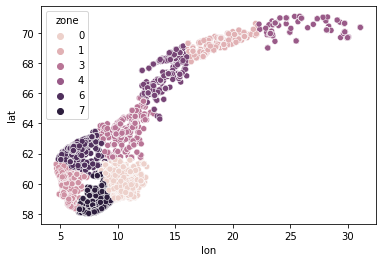

In [304]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(df[['lat','lon']])
df['zone'] = kmeans.labels_
sns.scatterplot(df.lon,df.lat,hue=df.zone)

### Store id

In [305]:
store_id_splitted = pd.DataFrame([i.split('-') for i in df['store_id']], columns=['str1', 'str2', 'str3', 'none'])

store_id_splitted = store_id_splitted.drop(columns=['none'])
store_id_splitted[store_id_splitted['str1'] == ''] = '1'
store_id_splitted[store_id_splitted['str2'] == ''] = '1'
store_id_splitted[store_id_splitted['str3'] == ''] = '1'
store_id_splitted

store_id_splitted['str1'] = store_id_splitted['str1'].astype('int')
store_id_splitted['str2'] = store_id_splitted['str2'].astype('int')
store_id_splitted['str3'] = store_id_splitted['str3'].astype('int')

In [306]:
df = df.join(store_id_splitted)

### Population density

In [307]:
df['pop_density'] = df.pop_grunnkrets/df.area_km2_grunnkrets

### Chain distance

Adherence to a chain is an important factor for shop revenue. Therefor we introduced this feature to see if a shop is close to a chain (which could be potentially strong competition for them)

In [121]:
reference_chain=df_extra[df_extra.chain_name!='No chain']
reference_chain = reference_chain.reset_index(drop=True)

dist_chain = np.zeros(len(df))
for i in df.index[df.chain_name == 'No chain']:
    min_dist_chain = 1000
    if (np.sum(reference_chain.grunnkrets_name==df.grunnkrets_name[i])):
        for k in reference_chain.index[reference_chain.grunnkrets_name==df.grunnkrets_name[i]]:
            distC = getDistance(df.lat[i],df.lon[i],reference_chain.lat[k],reference_chain.lon[k])
            if (distC<min_dist_chain) :
                min_dist_chain = distC
                
    elif (np.sum(reference_chain.municipality_name==df.municipality_name[i])):
        for m in reference_chain.index[reference_chain.municipality_name==df.municipality_name[i]]:
            distC = getDistance(df.lat[i],df.lon[i],reference_chain.lat[m],reference_chain.lon[m])
            if (distC<min_dist_chain):
                    min_dist_chain = distC
    else:
        for j in reference_chain.index:
            distC = getDistance(df.lat[i],df.lon[i],reference_chain.lat[j],reference_chain.lon[j])
            if (distC<min_dist_chain):
                min_dist_chain = distC
    dist_chain[i] = min_dist_chain

In [122]:
df['dist_chain'] = dist_chain

### Mall distance

Mall distance works with the same basic idea as chain distance but for the mall feature. (it usually takes more than 20 min to finish)

In [125]:
reference=df_extra[df_extra.mall_name!='No mall']
reference = reference.reset_index(drop=True)

dist_mall = np.zeros(len(df))
for i in df.index[df.mall_name == 'No mall']:
    min_dist_mall = 1000
    if (np.sum(reference.grunnkrets_name==df.grunnkrets_name[i])):
        for k in reference.index[reference.grunnkrets_name==df.grunnkrets_name[i]]:
            distM = getDistance(df.lat[i],df.lon[i],reference.lat[k],reference.lon[k])
            if (distM<min_dist_mall) :
                min_dist_mall = distM
                
    elif (np.sum(reference.municipality_name==df.municipality_name[i])):
        for m in reference.index[reference.municipality_name==df.municipality_name[i]]:
            distM = getDistance(df.lat[i],df.lon[i],reference.lat[m],reference.lon[m])
            if (distM<min_dist_mall):
                    min_dist_mall = distM
    else:
        for j in reference.index:
            distM = getDistance(df.lat[i],df.lon[i],reference.lat[j],reference.lon[j])
            if (distM<min_dist_mall):
                min_dist_mall = distM
    dist_mall[i] = min_dist_mall

In [126]:
df['dist_mall'] = dist_mall

### Bus distance

In [350]:
min_dist=np.zeros(len(df))+1e8
for jj in range(len(df)):
    ShopPos = get_cartesian(df.lat[jj],df.lon[jj])
    for ii in range(len(busstops)):
        BusPos = get_cartesian(busstops.lat[ii],busstops.lon[ii])
        distance = np.linalg.norm(BusPos-ShopPos)
        if(distance<min_dist[jj]):
            min_dist[jj]=distance

In [352]:
df['min_dist'] = min_dist

C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Feature selection

We tested the model with different features choices, increasing the complexity.

1) Simple model with some of the features already given

2) More complex model with some of the features already given

3) Adding one at the time the new features, checking the performance among all the model

4) Identify the combination of features that gives the best and stable results

In [249]:
selected_features = ['chain_name', 'mall_name', 'municipality_name','area_km2_municipality', 'all_households', 'singles',
                     'couple_without_children', 'couple_with_children', 'other_households','single_parent_with_children', 
                     'pop_grunnkrets','mean_age', 'pop_municipality','chain_rank','lv2_desc','lv4_desc','hierarchy_rank',
                     'dist_chain','dist_mall','pop_density', 'min_dist','infraScore','zone'] #'str1', 'str2','str3'
cat = ['chain_name','mall_name','municipality_name','lv2_desc','lv4_desc']
cat_catohe = ['amount_pop_municipality']
cat_catohepca = ['cat_income','cat_single', 'cat_all_households', 'cat_couple_without_children','cat_couple_with_children', 
                 'cat_other_households','cat_single_parent_with_children']
num_scaled = ['area_km2_municipality','all_households','singles', 'couple_without_children', 'couple_with_children',
              'other_households', 'single_parent_with_children', 'mean_age','chain_rank','pop_grunnkrets','pop_municipality',
              'pop_density','dist_chain','dist_mall','infraScore']
num_norm = ['area_km2_municipality','all_households','singles', 'couple_without_children', 'couple_with_children',
            'other_households', 'single_parent_with_children', 'mean_age']
num_max = ['chain_rank']
num_quantil = ['pop_grunnkrets','pop_municipality','pop_density','dist_chain','dist_mall','infraScore']

### Training and test set

In [129]:
from sklearn.model_selection import train_test_split

In [308]:
test_set = df[12859:]
df=df[:12859]

## Encoding for categorical features

### Cat boost encoder

In [310]:
import category_encoders as ce

In [311]:
encoder=ce.cat_boost.CatBoostEncoder(cols=cat,
                                     random_state=None, sigma=None, a=1)
encoder.fit(df,revenue)
df = encoder.transform(df)
test_set = encoder.transform(test_set)

### Label encoder

In [312]:
from sklearn.preprocessing import LabelEncoder

In [313]:
le = LabelEncoder()
train_test = df.append(test_set).reset_index().drop(columns=['index'])

# Chain name
le.fit(train_test['chain_name'])
train_test['chain_name'] = le.transform(train_test['chain_name'])

# Mall name
le.fit(train_test['mall_name'])
train_test['mall_name'] = le.transform(train_test['mall_name'])

# Municipality name
le.fit(train_test['municipality_name'])
train_test['municipality_name'] = le.transform(train_test['municipality_name'])

# Level 2 description
le.fit(train_test['lv2_desc'])
train_test['lv2_desc'] = le.transform(train_test['lv2_desc'])

# Level 4 description
le.fit(train_test['lv4_desc'])
train_test['lv4_desc'] = le.transform(train_test['lv4_desc'])

### One Hot Encoder

In [314]:
from sklearn.preprocessing import OneHotEncoder

In [315]:
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
ohe.fit(df[cat_catohe])
train_I = ohe.transform(df[cat_catohe])
test_I = ohe.transform(test_set[cat_catohe])

amount_pop_dataframe = pd.DataFrame(data = train_I, columns=['few','normal','test'])
amount_pop_dataframe_test = pd.DataFrame(data = test_I, columns=['few','normal','test'])

df = df.join(amount_pop_dataframe)
test_set = test_set.join(amount_pop_dataframe_test)

### One Hot Encoder and PCA

In [316]:
from sklearn.decomposition import PCA

In [317]:
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
ohe.fit(df[cat_catohepca])
ohe.fit(df[cat_catohepca])
train_I = ohe.transform(df[cat_catohepca])
test_I = ohe.transform(test_set[cat_catohepca])

pca = PCA(n_components=3)
pca.fit(train_I)
pca_train_I = pca.transform(train_I)
pca_test_I = pca.transform(test_I)
principalDf_train_I = pd.DataFrame(data = pca_train_I
             , columns = ['principal component 1I', 'principal component 2I','principal component 3I'])
principalDf_test_I = pd.DataFrame(data = pca_test_I
             , columns = ['principal component 1I', 'principal component 2I','principal component 3I'])

print(pca.explained_variance_ratio_)

df[['principal component 1I', 'principal component 2I','principal component 3I']] =principalDf_train_I
test_set[['principal component 1I', 'principal component 2I','principal component 3I']] =principalDf_test_I

[0.46228384 0.13735778 0.10526717]


## Scaler for numerical features

Starting applying different type of scaler on all the numerical features selected.

Applying different scaler based on the type of the numericaf feature.

In [318]:
from sklearn import preprocessing

In [319]:
df_num = df[num_scaled]
test_num = test_set[num_scaled]
names=df_num.columns

### Min Max Scaler

In [320]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

df_scaled = scaler.fit_transform(df_num)
test_scaled = scaler.transform(test_num)

In [321]:
from sklearn.preprocessing import StandardScaler

Scale only normal distributed numerical values

In [322]:
df_num_norm = df[num_norm]
test_num_norm = test_set[num_norm]
names=df_num_norm.columns

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler = preprocessing.StandardScaler()

df_scaled = scaler.fit_transform(df_num_norm)
test_scaled = scaler.transform(test_num_norm)

# ADDING PLOT TO SHOW THE NORMAL DISTRIBUTION (?)

Scale all consistently distributed numerical values

In [323]:
df_num_max = df[num_max]
test_num_max = test_set[num_max]
names=df_num_max.columns

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

df_scaled = scaler.fit_transform(df_num_max)
test_scaled = scaler.transform(test_num_max)

### Standard Scaler

In [324]:
from sklearn.preprocessing import StandardScaler

In [325]:
scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_num)
test_scaled = scaler.transform(test_num)

### Robust Scaler

In [326]:
from sklearn.preprocessing import RobustScaler

In [327]:
scaler = RobustScaler()

df_scaled = scaler.fit_transform(df_num)
test_scaled = scaler.transform(test_num)

### Power Transformer

In [328]:
from sklearn.preprocessing import PowerTransformer

In [329]:
scaler = PowerTransformer(method='yeo-johnson')

df_scaled = scaler.fit_transform(df_num)
test_scaled = scaler.transform(test_num)

C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


### Quantile Transformer

In [330]:
from sklearn.preprocessing import QuantileTransformer

Scale all numerical values with outliers

In [331]:
qt = QuantileTransformer(n_quantiles=100, random_state=0)

df_quanti = pd.DataFrame()
test_quanti = pd.DataFrame()
for i in num_quantil:
    X = df[i].to_numpy()
    X = np.reshape(X,[len(X),1])
    visualizer = qt.fit_transform(X)
    df_quanti[i] = np.squeeze(visualizer)
    Y = test_set[i].to_numpy()
    Y = np.reshape(Y,[len(Y),1])
    visualizer = qt.transform(Y)
    test_quanti[i] = np.squeeze(visualizer)

## Model data

### To test the model

In [288]:
revenue = stores_train.revenue

In [289]:
df = df[selected_features]
log_offset = 0.01
X_train,X_test,y_train,y_test= train_test_split(df,revenue,test_size=0.20,shuffle=True)
y_train = np.log(y_train+log_offset)
X_train = X_train[y_train>-2]
y_train = y_train[y_train>-2]

### For the submission

In [ ]:
X_train = df[selected_features]
X_test = test_set[selected_features]
y_train = np.log(revenue+log_offset)

X_train = X_train[y_train>-2]
y_train = y_train[y_train>-2]

## Simple Model
1: Linear regression


2: SVR



3: Decision Tree



4: Random Forest


In [171]:
from sklearn.linear_model import LinearRegression
from sklearn import svm 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 

In [172]:
# Linear Regression
model1 = LinearRegression()

# SVR
model2=svm.SVR(kernel='rbf')


# Decision Tree
model3 = DecisionTreeRegressor(max_depth = 5,
    min_samples_split = 10,
    min_samples_leaf = 2,
    random_state=42)

# Random Forest
model4 = RandomForestRegressor(
    n_estimators=50,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

### Fit the model

In [182]:
model1.fit(X_train,y_train)

model2.fit(X_train,y_train)

model3.fit(X_train,y_train)

model4.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

### Prediction

In [183]:
prediction1 = model1.predict(X_test)
prediction1 = np.exp(prediction1)-log_offset
prediction1[prediction1<0] = 0

prediction2=model2.predict(X_test_sc)
prediction2 = np.exp(prediction2)-log_offset
prediction2[prediction2<0] = 0

prediction3 = model3.predict(X_test)
prediction3 = np.exp(prediction3)-log_offset
prediction3[prediction3<0] = 0

prediction4 = model4.predict(X_test)
prediction4 = np.exp(prediction4)-log_offset
prediction4[prediction4<0] = 0

print('RMSLE\nLinear Regression: ' ,rmsle(prediction1,y_test), '\nSVR: ', rmsle(prediction2,y_test), '\nDecision Tree: ',
     rmsle(prediction3,y_test), '\nRandom Forest: ', rmsle(prediction4,y_test))

RMSLE
Linear Regression:  0.7342427019287928 
SVR:  1.4650314042115218 
Decision Tree:  0.7229120434607372 
Random Forest:  0.7238693213094388


### Feature importance

Text(0.5, 1.0, 'Random Forest')

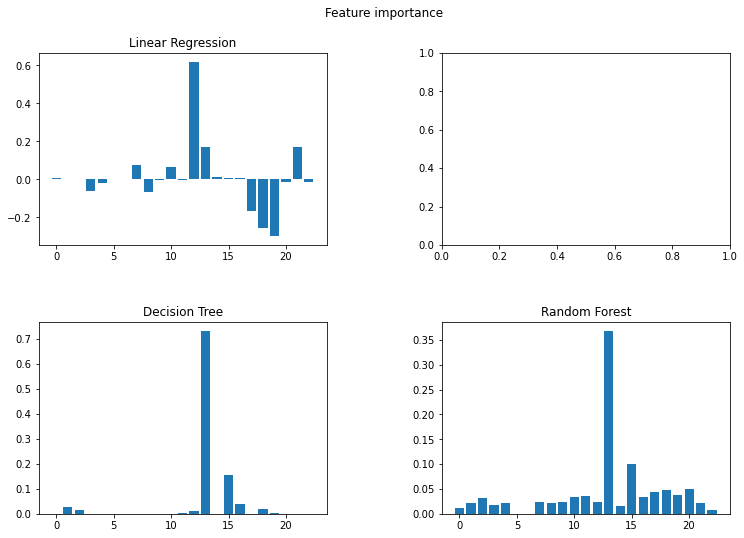

In [185]:
importance1 = model1.coef_
importance3 = model3.feature_importances_
importance4 = model4.feature_importances_
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(12,8),ncols=2,nrows=2)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.suptitle('Feature importance')
ax1.bar([x for x in range(len(importance1))],importance1)
ax1.set_title('Linear Regression')
ax3.bar([x for x in range(len(importance1))],importance3)
ax3.set_title('Decision Tree')
ax4.bar([x for x in range(len(importance1))],importance4)
ax4.set_title('Random Forest')

In [186]:
for i in range(len(df.columns)):
    print([i,df.columns[i]])

[0, 'chain_name']
[1, 'mall_name']
[2, 'municipality_name']
[3, 'area_km2_municipality']
[4, 'all_households']
[5, 'singles']
[6, 'couple_without_children']
[7, 'couple_with_children']
[8, 'other_households']
[9, 'single_parent_with_children']
[10, 'pop_grunnkrets']
[11, 'mean_age']
[12, 'pop_municipality']
[13, 'chain_rank']
[14, 'lv2_desc']
[15, 'lv4_desc']
[16, 'hierarchy_rank']
[17, 'dist_chain']
[18, 'dist_mall']
[19, 'pop_density']
[20, 'min_dist']
[21, 'infraScore']
[22, 'zone']


### Prediction vs True values

Text(0.5, 1.0, 'Random Forest')

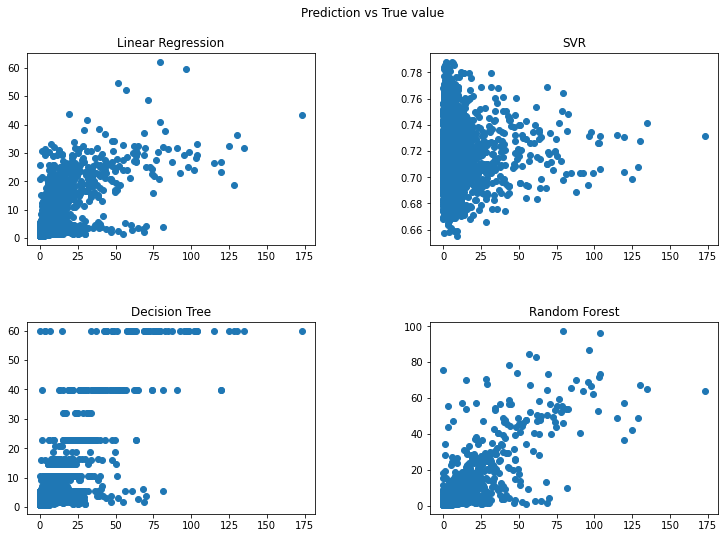

In [187]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(12,8),ncols=2,nrows=2)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.suptitle('Prediction vs True value')
ax1.scatter(y_test,prediction1)
ax1.set_title('Linear Regression')
ax2.scatter(y_test,prediction2)
ax2.set_title('SVR')
ax3.scatter(y_test,prediction3)
ax3.set_title('Decision Tree')
ax4.scatter(y_test,prediction4)
ax4.set_title('Random Forest')

## Complex model

5: Cat Boost Regressor

6: Ada Boost Regressor

7: Gradient Boosting Regressor

8: LGBM Regressor

In [190]:
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xg

In [191]:
# Cat Boost Regressor
model5 = CatBoostRegressor(
    n_estimators=500,
    random_state=42,
    l2_leaf_reg = 1,
    learning_rate = 0.07,
    depth = 4
)

# Ada Boost Regressor
model6 = AdaBoostRegressor(
    n_estimators=1500,
    learning_rate=0.005,
    loss='square',
    random_state=42
)

# Gradient Boosting Regressor
model7 = GradientBoostingRegressor(
    learning_rate=0.05,
    n_estimators=1000,
    subsample=1.0, 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=5, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=0, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0
)

# LGBM Regressor
model8 = lgb.LGBMRegressor(
    num_leaves=3,
    max_depth=3, #5, 
    random_state=42, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=200, #1000,
    colsample_bytree=0.95,
    subsample=0.7, #0.9,
    learning_rate=0.05
)

# XGBoost
model9 = xg.XGBRegressor(n_estimators=1000,
                        max_depth=5,
                        learning_rate = 0.05)

### Fit the model

In [192]:
model5.fit(X_train,y_train)

model6.fit(X_train,y_train)

model7.fit(X_train,y_train)

model8.fit(X_train,y_train)

model9.fit(X_train,y_train)

0:	learn: 1.3496274	total: 151ms	remaining: 2m 31s
1:	learn: 1.3438507	total: 155ms	remaining: 1m 17s
2:	learn: 1.3381237	total: 157ms	remaining: 52.2s
3:	learn: 1.3324548	total: 160ms	remaining: 39.8s
4:	learn: 1.3270214	total: 164ms	remaining: 32.6s
5:	learn: 1.3215885	total: 166ms	remaining: 27.6s
6:	learn: 1.3162536	total: 169ms	remaining: 24s
7:	learn: 1.3108394	total: 172ms	remaining: 21.3s
8:	learn: 1.3056160	total: 175ms	remaining: 19.3s
9:	learn: 1.3006298	total: 178ms	remaining: 17.6s
10:	learn: 1.2955754	total: 181ms	remaining: 16.2s
11:	learn: 1.2905792	total: 184ms	remaining: 15.1s
12:	learn: 1.2855607	total: 186ms	remaining: 14.1s
13:	learn: 1.2805577	total: 189ms	remaining: 13.3s
14:	learn: 1.2756388	total: 191ms	remaining: 12.6s
15:	learn: 1.2710072	total: 194ms	remaining: 11.9s
16:	learn: 1.2666464	total: 197ms	remaining: 11.4s
17:	learn: 1.2621717	total: 199ms	remaining: 10.9s
18:	learn: 1.2578550	total: 201ms	remaining: 10.4s
19:	learn: 1.2536552	total: 204ms	remaini

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Prediction

In [193]:
prediction5 = model5.predict(X_test)
prediction5 = np.exp(prediction5)-log_offset
prediction5[prediction5<0] = 0

prediction6=model6.predict(X_test_sc)
prediction6 = np.exp(prediction6)-log_offset
prediction6[prediction6<0] = 0

prediction7 = model7.predict(X_test)
prediction7 = np.exp(prediction7)-log_offset
prediction7[prediction7<0] = 0

prediction8 = model8.predict(X_test)
prediction8 = np.exp(prediction8)-log_offset
prediction8[prediction8<0] = 0

prediction9 = model9.predict(X_test)
prediction9 = np.exp(prediction9)-log_offset
prediction9[prediction9<0] = 0

print('RMSLE\nCat Boost RegressorAda Boost Regressor: ' ,rmsle(prediction5,y_test), '\nAda Boost Regressor: ', 
      rmsle(prediction6,y_test), '\nGradient Boosting Regressor: ',rmsle(prediction7,y_test), '\nLGBM Regressor: ', 
      rmsle(prediction8,y_test), '\nXGBoost: ',rmsle(prediction9,y_test))

RMSLE
Cat Boost RegressorAda Boost Regressor:  0.7003439052501889 
Ada Boost Regressor:  1.2028809672917598 
Gradient Boosting Regressor:  0.72231150429695 
LGBM Regressor:  0.7048558293407079 
XGBoost:  0.7185588769102974


### Feature importance

Text(0.5, 1.0, 'LGBM Regressor')

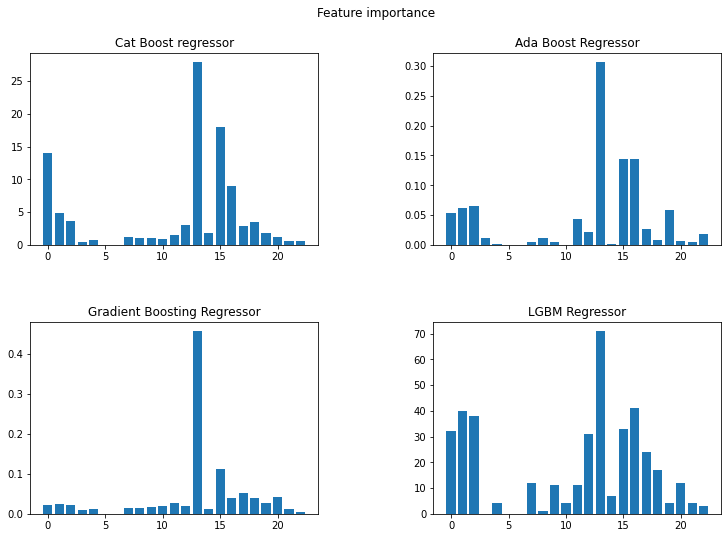

In [196]:
importance5 = model5.feature_importances_
importance6 = model6.feature_importances_
importance7 = model7.feature_importances_
importance8 = model8.feature_importances_
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(12,8),ncols=2,nrows=2)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.suptitle('Feature importance')
ax1.bar([x for x in range(len(importance5))],importance5)
ax1.set_title('Cat Boost regressor')
ax2.bar([x for x in range(len(importance6))],importance6)
ax2.set_title('Ada Boost Regressor')
ax3.bar([x for x in range(len(importance7))],importance7)
ax3.set_title('Gradient Boosting Regressor')
ax4.bar([x for x in range(len(importance8))],importance8)
ax4.set_title('LGBM Regressor')

In [197]:
for i in range(len(df.columns)):
    print([i,df.columns[i]])

[0, 'chain_name']
[1, 'mall_name']
[2, 'municipality_name']
[3, 'area_km2_municipality']
[4, 'all_households']
[5, 'singles']
[6, 'couple_without_children']
[7, 'couple_with_children']
[8, 'other_households']
[9, 'single_parent_with_children']
[10, 'pop_grunnkrets']
[11, 'mean_age']
[12, 'pop_municipality']
[13, 'chain_rank']
[14, 'lv2_desc']
[15, 'lv4_desc']
[16, 'hierarchy_rank']
[17, 'dist_chain']
[18, 'dist_mall']
[19, 'pop_density']
[20, 'min_dist']
[21, 'infraScore']
[22, 'zone']


### Prediction vs True values

Text(0.5, 1.0, 'LGBMRegressor')

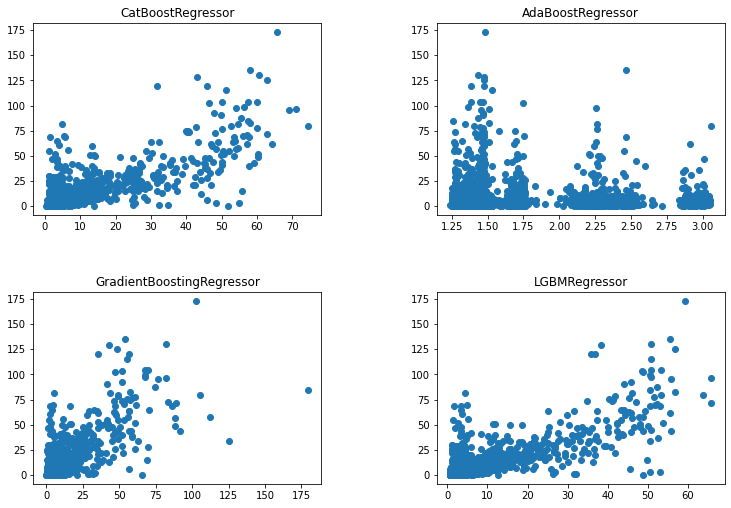

In [199]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(12,8),ncols=2,nrows=2)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
ax1.scatter(prediction5,y_test)
ax2.scatter(prediction6,y_test)
ax3.scatter(prediction7,y_test)
ax4.scatter(prediction8,y_test)
ax1.set_title('CatBoostRegressor')
ax2.set_title('AdaBoostRegressor')
ax3.set_title('GradientBoostingRegressor')
ax4.set_title('LGBMRegressor')

## Cross Validation

In [200]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict

In [201]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
nfeatures = X_train.shape[1]
SEED = 42 # for reproducibility
NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
) # K-Folds cross-validator

# oof = out of fold
def get_oof(clf, x_train, y_train,x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = x_train.iloc[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    oof_test[:] = oof_test_skf.mean(axis=0)
    
    return oof_train.reshape(-1), oof_test.reshape(-1)

In [203]:
lr_oof_train, lr_oof_test = get_oof(model1, X_train, y_train, X_test)

svr_oof_train, svr_oof_test = get_oof(model2, X_train, y_train, X_test)

dt_oof_train, dt_oof_test = get_oof(model3, X_train, y_train,X_test)

rf_oof_train, rf_oof_test = get_oof(model4, X_train, y_train,X_test)

cb_oof_train, cb_oof_test = get_oof(model5, X_train, y_train,X_test)

ab_oof_train, ab_oof_test = get_oof(model6, X_train, y_train,X_test)

gb_oof_train, gb_oof_test = get_oof(model7, X_train, y_train,X_test)

lgbm_oof_train, lgbm_oof_test = get_oof(model8, X_train, y_train,X_test)

xgb_oof_train, xgb_oog_test = get_oof(model9,X_train, y_train,X_test)

0:	learn: 1.3517282	total: 2.52ms	remaining: 2.52s
1:	learn: 1.3460823	total: 4.71ms	remaining: 2.35s
2:	learn: 1.3405337	total: 7.11ms	remaining: 2.36s
3:	learn: 1.3349923	total: 9.46ms	remaining: 2.35s
4:	learn: 1.3296472	total: 11.8ms	remaining: 2.34s
5:	learn: 1.3244332	total: 14.2ms	remaining: 2.35s
6:	learn: 1.3191979	total: 16.3ms	remaining: 2.31s
7:	learn: 1.3138930	total: 18.4ms	remaining: 2.29s
8:	learn: 1.3088564	total: 20.7ms	remaining: 2.28s
9:	learn: 1.3039253	total: 23.2ms	remaining: 2.29s
10:	learn: 1.2989448	total: 25.6ms	remaining: 2.3s
11:	learn: 1.2940605	total: 27.9ms	remaining: 2.3s
12:	learn: 1.2893858	total: 30.4ms	remaining: 2.31s
13:	learn: 1.2845200	total: 32.7ms	remaining: 2.3s
14:	learn: 1.2798613	total: 34.7ms	remaining: 2.28s
15:	learn: 1.2752948	total: 37ms	remaining: 2.28s
16:	learn: 1.2709949	total: 39.1ms	remaining: 2.26s
17:	learn: 1.2664511	total: 41.1ms	remaining: 2.24s
18:	learn: 1.2622168	total: 43.2ms	remaining: 2.23s
19:	learn: 1.2580455	total:

In [204]:
lr_oof_test = np.exp(lr_oof_test) - log_offset

svr_oof_test = np.exp(svr_oof_test) - log_offset

dt_oof_test = np.exp(dt_oof_test) - log_offset

rf_oof_test = np.exp(rf_oof_test) - log_offset

cb_oof_test = np.exp(cb_oof_test) - log_offset

ab_oof_test = np.exp(ab_oof_test) - log_offset

gb_oof_test = np.exp(gb_oof_test) - log_offset

lgbm_oof_test = np.exp(lgbm_oof_test) - log_offset

xgb_oof_test = np.exp(xgb_oog_test) - log_offset

print('RMSLE\nLinear Regression: ' ,rmsle(lr_oof_test,y_test), '\nSVR: ', rmsle(svr_oof_test,y_test), '\nDecision Tree: ',
     rmsle(dt_oof_test,y_test), '\nRandom Forest: ', rmsle(rf_oof_test,y_test), '\nCat Boost Regressor: ',rmsle(cb_oof_test,y_test),
     '\nAda Boost Regressor: ',rmsle(ab_oof_test,y_test), '\nGradient Boosting Regressor: ',rmsle(gb_oof_test,y_test),
     '\nLGBM Regressor: ', rmsle(lgbm_oof_test,y_test))

RMSLE
Linear Regression:  0.7342450394621631 
SVR:  0.7200451040377307 
Decision Tree:  0.7163790128971504 
Random Forest:  0.7138152297039234 
Cat Boost Regressor:  0.7007187759677485 
Ada Boost Regressor:  0.7504464973277839 
Gradient Boosting Regressor:  0.7136789108154444 
LGBM Regressor:  0.7044545924323535


## Hyperparameter Optimization

In [205]:
from sklearn.model_selection import GridSearchCV

Cat Boost Regressor

In [208]:
model5 = CatBoostRegressor()
grid_cb = {'iterations': [500,800, 1000],
        'learning_rate': [0.01,0.05,0.07],
        'depth': [2,4, 5,8],
        'l2_leaf_reg': [1]}
model5.grid_search(grid_cb,
                   X=df,
                   y=revenue,
                   cv=5)

0:	learn: 17.3690139	test: 17.1433229	best: 17.1433229 (0)	total: 14.1ms	remaining: 7.04s
1:	learn: 17.2613207	test: 17.0295943	best: 17.0295943 (1)	total: 16.1ms	remaining: 4s
2:	learn: 17.1568079	test: 16.9192162	best: 16.9192162 (2)	total: 18ms	remaining: 2.99s
3:	learn: 17.0532505	test: 16.8062320	best: 16.8062320 (3)	total: 20.1ms	remaining: 2.5s
4:	learn: 16.9498177	test: 16.6924070	best: 16.6924070 (4)	total: 22.2ms	remaining: 2.2s
5:	learn: 16.8467021	test: 16.5801711	best: 16.5801711 (5)	total: 24.6ms	remaining: 2.03s
6:	learn: 16.7447330	test: 16.4691298	best: 16.4691298 (6)	total: 26.8ms	remaining: 1.89s
7:	learn: 16.6446270	test: 16.3593526	best: 16.3593526 (7)	total: 28.9ms	remaining: 1.78s
8:	learn: 16.5459417	test: 16.2523468	best: 16.2523468 (8)	total: 30.9ms	remaining: 1.69s
9:	learn: 16.4501332	test: 16.1481017	best: 16.1481017 (9)	total: 32.8ms	remaining: 1.61s
10:	learn: 16.3559953	test: 16.0436053	best: 16.0436053 (10)	total: 34.9ms	remaining: 1.55s
11:	learn: 16.2

{'params': {'depth': 4,
  'l2_leaf_reg': 1,
  'iterations': 500,
  'learning_rate': 0.07},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

{'params': {'depth': 4,'l2_leaf_reg': 1,'iterations': 500,'learning_rate': 0.07}

LGBM Regressor

In [209]:
grid_lgbm = {'learning_rate': [0.05], 'n_estimators': [100,200,300],
               'num_leaves': [3,5],'max_depth' : [3,5],
                'subsample': [0.7]}
gd=GridSearchCV(estimator=lgb.LGBMRegressor(),param_grid=grid_lgbm,verbose=True)
gd.fit(df,revenue)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.420936762232251
LGBMRegressor(learning_rate=0.05, max_depth=3, n_estimators=300, num_leaves=5,
              subsample=0.7)


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    5.9s finished


## AutoML with h2o

In [210]:
import h2o
from h2o.automl import H2OAutoML

In [211]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         17 hours 6 mins
H2O_cluster_timezone:       +01:00
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.2
H2O_cluster_version_age:    16 days
H2O_cluster_name:           H2O_from_python_giuli_mugvr3
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.489 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.6.10 final
--------------------------  -----------------------------

In [290]:
X_train['revenue'] = y_train
train_h2o = h2o.H2OFrame(X_train)
test_h2o = h2o.H2OFrame(X_test)
x= train_h2o.columns
y = 'revenue'
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### Fit the model

In [291]:
aml = H2OAutoML(max_models=10, seed=1)
aml.train(x=x, y=y, training_frame=train_h2o)

AutoML progress: |█
14:06:41.946: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_3_20221113_140641

No summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.6959852455083418
RMSE: 0.8342573017411007
MAE: 0.6271534268691181
RMSLE: NaN
Mean Residual Deviance: 0.6959852455083418
R^2: 0.6219674179976946
Null degrees of freedom: 9896
Residual degrees of freedom: 9888
Null deviance: 18221.09072797835
Residual deviance: 6888.165974796059
AIC: 24519.53110994546

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.9128507451476021
RMSE: 0.9554322294896703
MAE: 0.7208321048109054
RMSLE: NaN
Mean Residual Deviance: 0.9128507451476021
R^2: 0.5041743680660409
Null degrees of freedom: 9896
Residual degrees of freedom: 9889
Null deviance: 18227.576897881725
Residual deviance: 9034.483824725818
AIC: 27202.03227247494

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     0.720379  0.0182248  0.740316      0.731818      0.72471       0.711014      0.694039
mean_residual_deviance  0.91159   0.047183   0.971617      0.909788      0.926462      0.909721      0.84036
mse                     0.91159   0.047183   0.971617      0.909788      0.926462      0.909721      0.84036
null_deviance           3645.52   225.795    3866.2        3701.82       3759.65       3626.8        3273.11
r2                      0.504443  0.0125122  0.490844      0.506952      0.500021      0.500051      0.524346
residual_deviance       1806.92   153.878    1968.5        1821.4        1878.87       1810.34       1555.51
rmse                    0.954514  0.0248356  0.985706      0.953828      0.962529      0.953793      0.916711
rmsle                   nan       0          nan           nan           nan           nan           nan

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [292]:
se = aml.leader
metalearner = h2o.get_model(se.metalearner()['name'])

C:\Users\giuli\anaconda3\envs\py36\lib\site-packages\h2o\estimators\stackedensemble.py:929: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  H2ODeprecationWarning


### Prediction

In [293]:
y_pred10 = aml.predict(test_h2o)
y_pred10 = h2o.as_list(y_pred10).values
y_pred10 = np.exp(y_pred10.reshape(-1,))-log_offset
print('RMSLE autoML:', rmsle(y_pred10,y_test))

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
RMSLE autoML: 0.705382320778838


### Feature importance

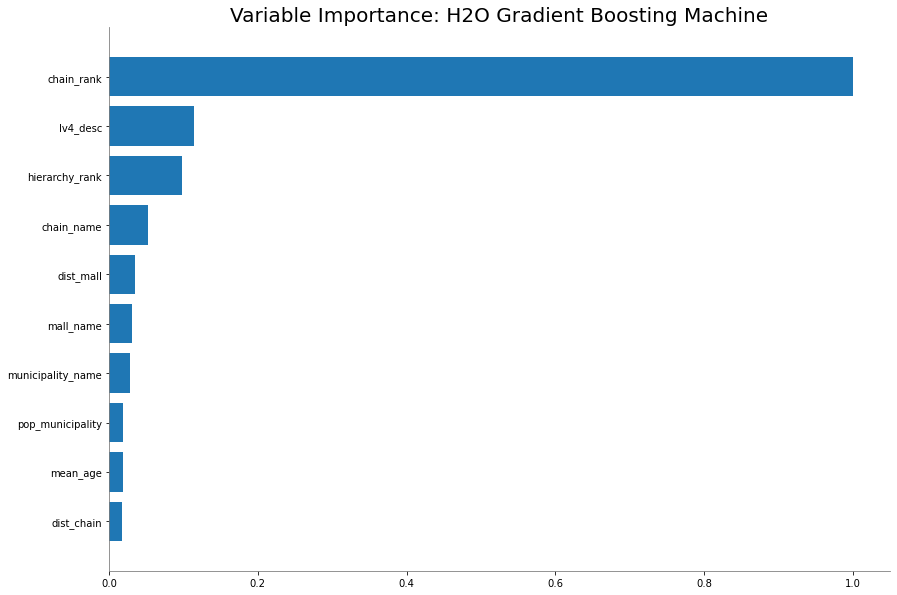

<Figure size 432x288 with 0 Axes>

In [294]:
model = h2o.get_model(metalearner.varimp()[0][0])
model.varimp_plot()

### Prediction vs True values

Text(0.5, 1.0, 'AutoML')

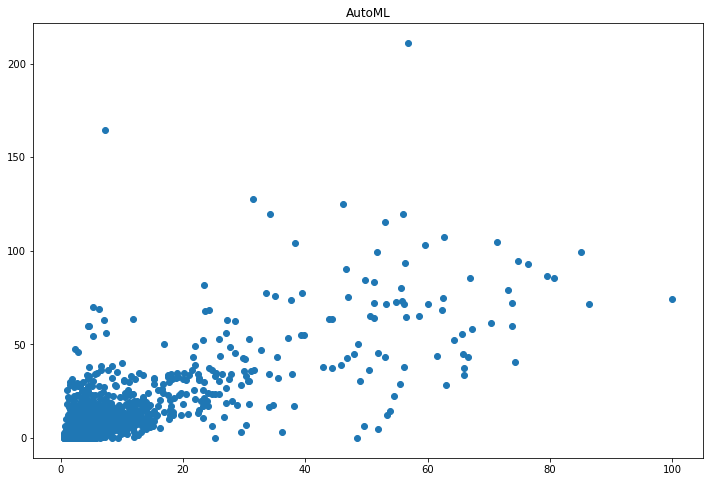

In [296]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.scatter(y_pred10,y_test)
ax1.set_title('AutoML')

## Creating a Submission

In [ ]:
# Predict on the test set 
X_test = stores_test  

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = X_test.store_id 
submission['predicted'] = np.asarray(y_pred9)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('sample_submission.csv', index=False)
submission